#**TUGAS 3 ANALISIS DATA MEDIS | SURVIVAL ANALYSIS PENYAKIT JANTUNG**

Anggota Kelompok:
1. Nafisahika Putri Herra (164221039)
2. Najla Dhia Rusydi (164221043)
3. Rashiqa Dewi Nariswari (164221044)
4. Shiba Salsabilla (164221078)

# Import Libraries

In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install qbstyles

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import shap
import optuna
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,  MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from qbstyles import mpl_style
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skew
palette1 = ['#FF5733', '#FFC300', '#DAF7A6', '#581845', '#900C3F']
palette2 = ['#3498DB', '#2ECC71', '#F39C12', '#8E44AD', '#E74C3C']
palette3 = ['#1ABC9C', '#2C3E50', '#F1C40F', '#8E44AD', '#E67E22']
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [ ]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Eksplorasi dan Analisis Data

In [ ]:
column_missing = df.isna().sum().rename('missing_values')
column_value = df.apply(lambda x:set(x.unique()),axis=0).rename('value')
column_max = df.max(numeric_only=True).rename('maximum')
column_type = df.dtypes.rename('data_type')

summary_df=pd.concat([column_missing, column_value, column_type, column_max],axis=1).fillna('-')
summary_df['number_of_value'] = summary_df['value'].apply(lambda x: len(x))
summary_df

,missing_values,value,data_type,maximum,number_of_value
Age,0,"{28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",int64,77.0,50
Sex,0,"{F, M}",object,-,2
ChestPainType,0,"{ATA, NAP, TA, ASY}",object,-,4
RestingBP,0,"{128, 0, 130, 131, 132, 133, 134, 135, 136, 13...",int64,200.0,67
Cholesterol,0,"{0, 518, 529, 564, 85, 603, 100, 110, 113, 117...",int64,603.0,222
FastingBS,0,"{0, 1}",int64,1.0,2
RestingECG,0,"{ST, Normal, LVH}",object,-,3
MaxHR,0,"{60, 63, 67, 69, 70, 71, 72, 73, 77, 78, 80, 8...",int64,202.0,119
ExerciseAngina,0,"{Y, N}",object,-,2
Oldpeak,0,"{0.0, 1.0, 2.0, 3.0, 1.5, 4.0, 0.5, 2.5, 5.0, ...",float64,6.2,53


In [ ]:
print("Duplicates in Dataset: ",df.duplicated().sum())
print("Dataset shape: ",df.shape)

Duplicates in Dataset:  0
Dataset shape:  (918, 12)


### Split Kategorik dan Numerikal Data

In [ ]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df["HeartDisease"] = df["HeartDisease"].replace({1 : "Yes", 0 : "No"})
df["FastingBS"] = df["FastingBS"].replace({1 : "Yes", 0 : "No"})



In [ ]:
numerical_features = ["Age", "RestingBP", "Cholesterol","MaxHR","Oldpeak"]
categorical_features = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [ ]:
print(df['ChestPainType'].value_counts().to_string(), end='\n\n')
print(df['RestingECG'].value_counts().to_string(), end='\n\n')
print(df['ExerciseAngina'].value_counts().to_string(), end='\n\n')
print(df['ST_Slope'].value_counts().to_string(), end='\n\n')
print(df['FastingBS'].value_counts().to_string(), end='\n\n')
print(df['HeartDisease'].value_counts().to_string(), end='\n\n')


ChestPainType
ASY    496
NAP    203
ATA    173
TA      46

RestingECG
Normal    552
LVH       188
ST        178

ExerciseAngina
N    547
Y    371

ST_Slope
Flat    460
Up      395
Down     63

FastingBS
No     704
Yes    214

HeartDisease
Yes    508
No     410



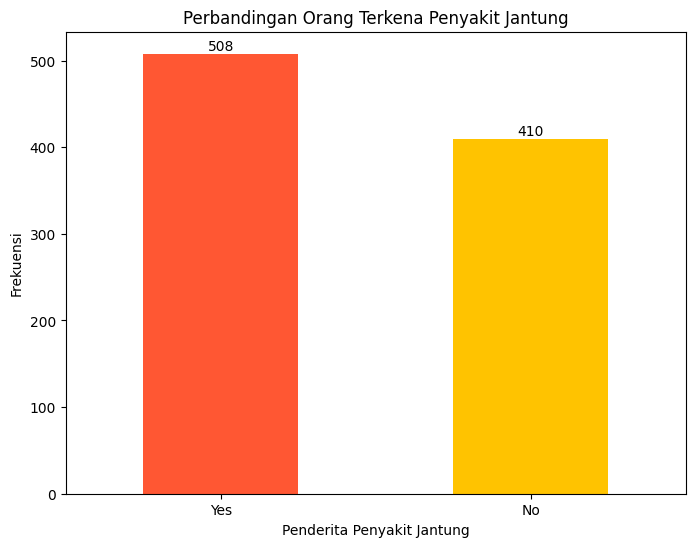

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))


# Plot the bar chart
ax = df["HeartDisease"].value_counts().plot(kind='bar', color=('#FF5733', '#FFC300'))

# Add frequency labels on top of each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.5, str(i.get_height()), ha='center', va='bottom')

plt.title('Perbandingan Orang Terkena Penyakit Jantung')
plt.xlabel('Penderita Penyakit Jantung')
plt.ylabel('Frekuensi')
plt.xticks(rotation=0)
plt.show()


Data sudah termasuk dalam kategori seimbang sehingga hasil prediksi tidak akan bias dan lebih akurat

### Variabel Numerik

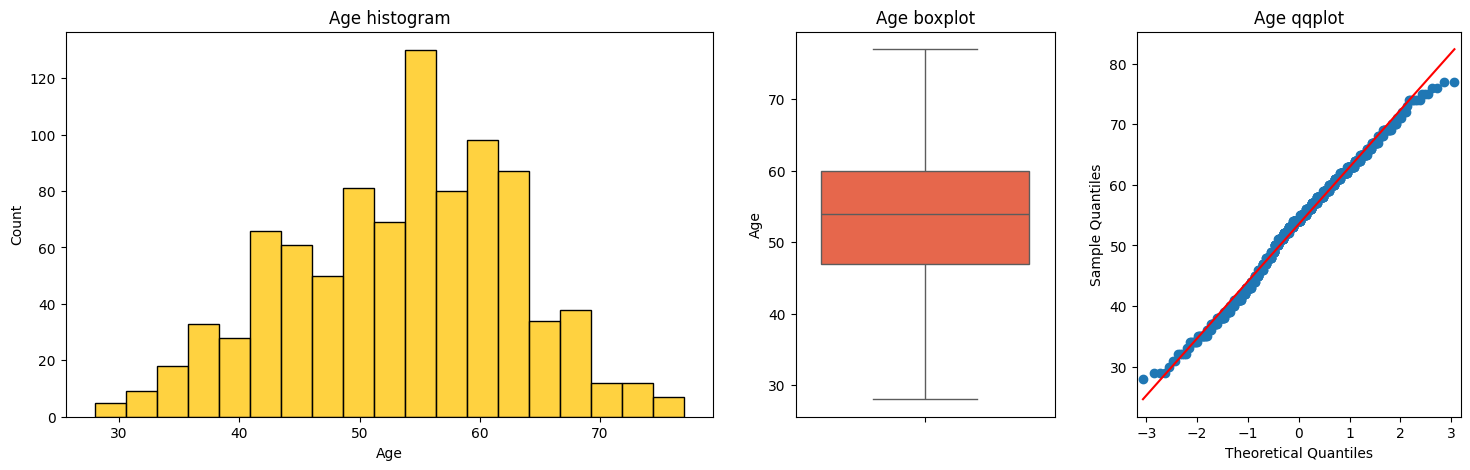

Nilai skew Age = -0.19561273124487544


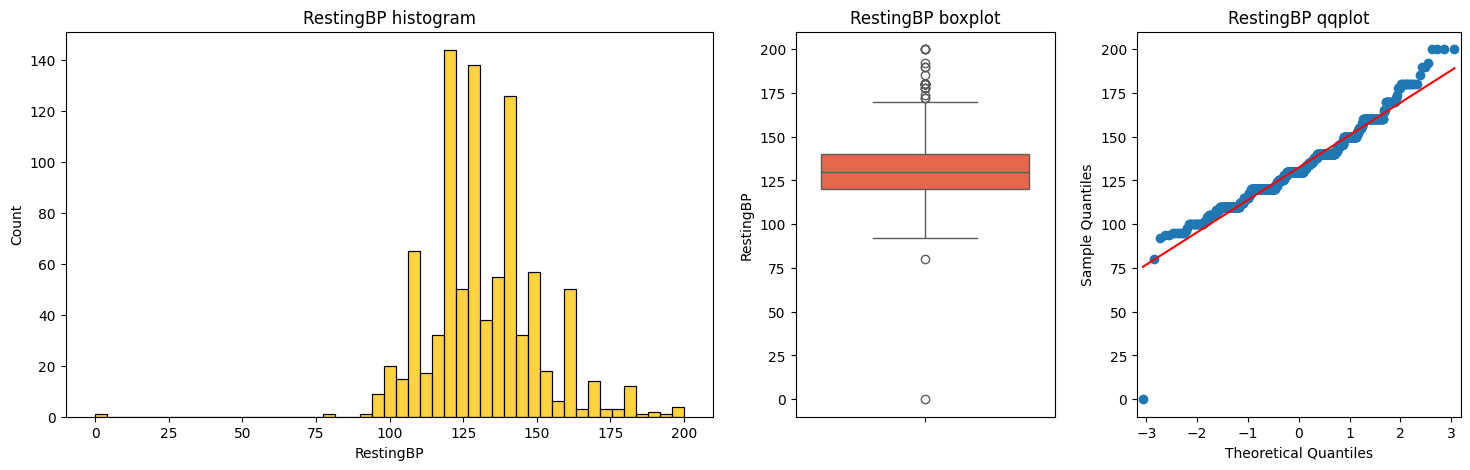

Nilai skew RestingBP = 0.17954532149156327


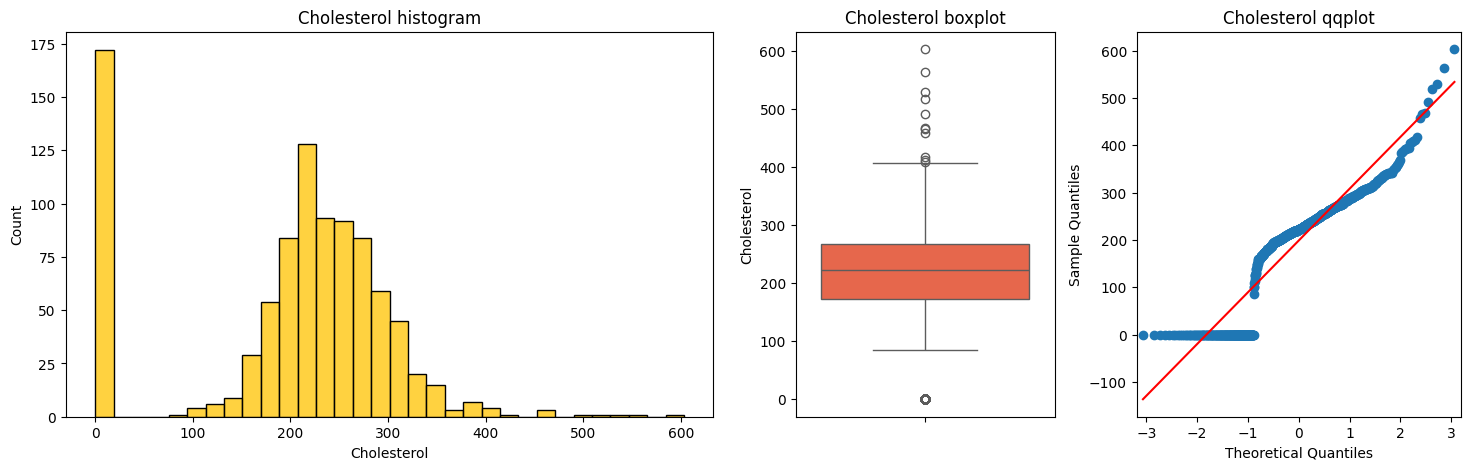

Nilai skew Cholesterol = -0.6090891046626045


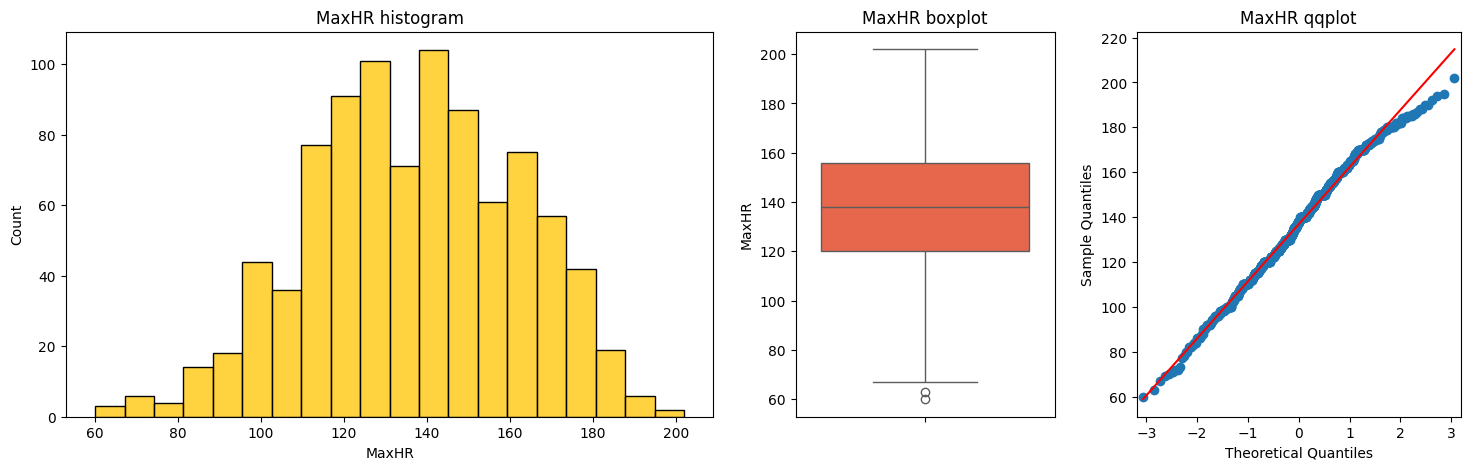

Nilai skew MaxHR = -0.14412342991429325


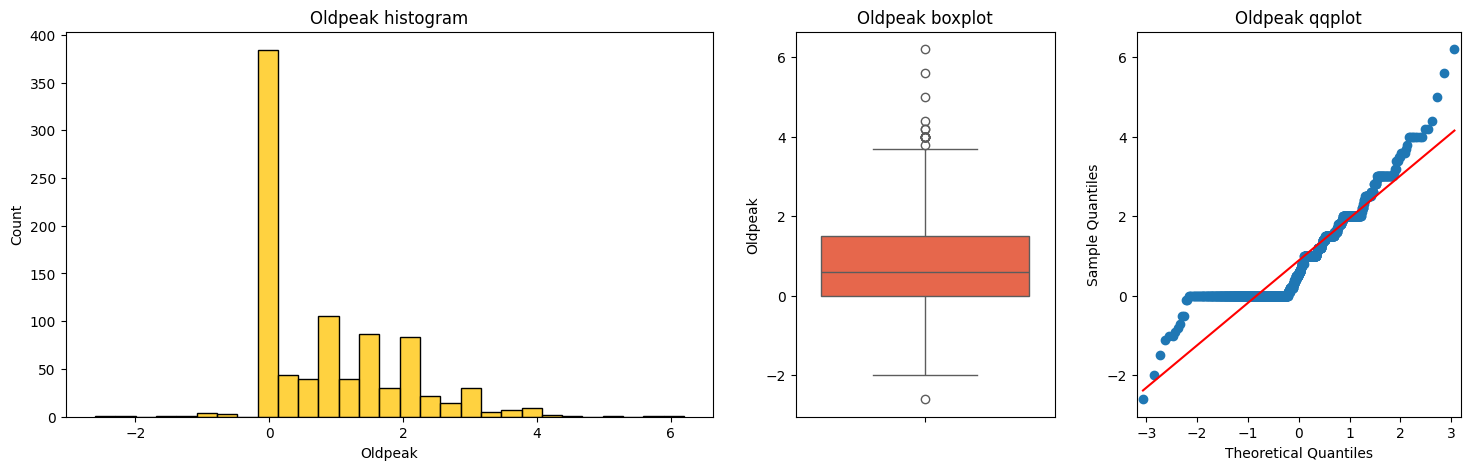

Nilai skew Oldpeak = 1.0211999031135828


In [ ]:
def generate_numerical_viz(data):
      for i in data:
        non_nan_data = data[data[i].notna()]

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 0.8, 1]})

        # Histogram
        sns.histplot(non_nan_data[i], ax=axes[0], color='#FFC300')
        axes[0].set_title(f"{i} histogram")

        # Boxplot
        sns.boxplot(non_nan_data[i], ax=axes[1], palette=palette1)
        axes[1].set_title(f"{i} boxplot")

        # QQplot

        qqplot(non_nan_data[i], ax=axes[2], line="s")
        axes[2].set_title(f"{i} qqplot")

        plt.show()

        # hitung skew
        print(f"Nilai skew {i} = {skew(non_nan_data[i])}")

generate_numerical_viz(df.drop(columns=(categorical_features)))

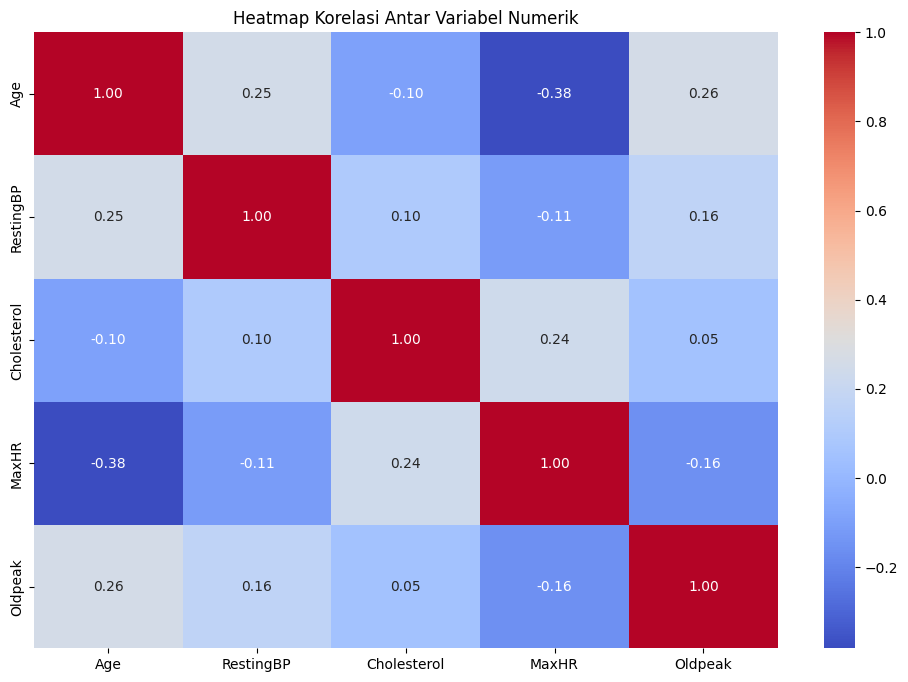

In [ ]:
df_numerik = df[numerical_features]

corr_numerik = df_numerik.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_numerik, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.show()

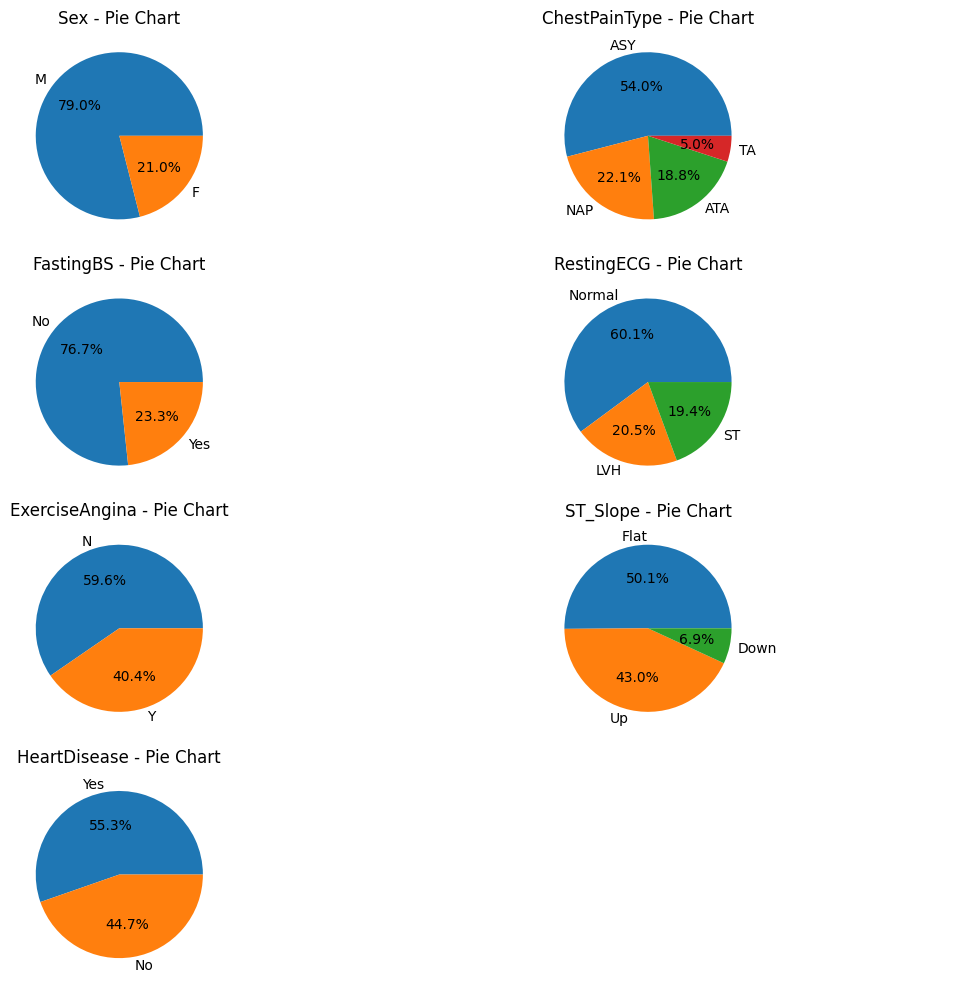

In [ ]:
def visualize_categorical(data, categoricals):
    num_plots = len(categoricals)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

    for i, column in enumerate(categoricals):
        row = i // num_cols
        col = i % num_cols

        data_to_plot = data
        data_to_plot[column].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[row, col])
        axes[row, col].set_title(f'{column} - Pie Chart')
        axes[row, col].set_ylabel('')

    # Hide any empty subplots
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


# Call visualize_categorical with the original DataFrame and categorical features
visualize_categorical(df, categorical_features)



### Numerical Dengan HeartDisease

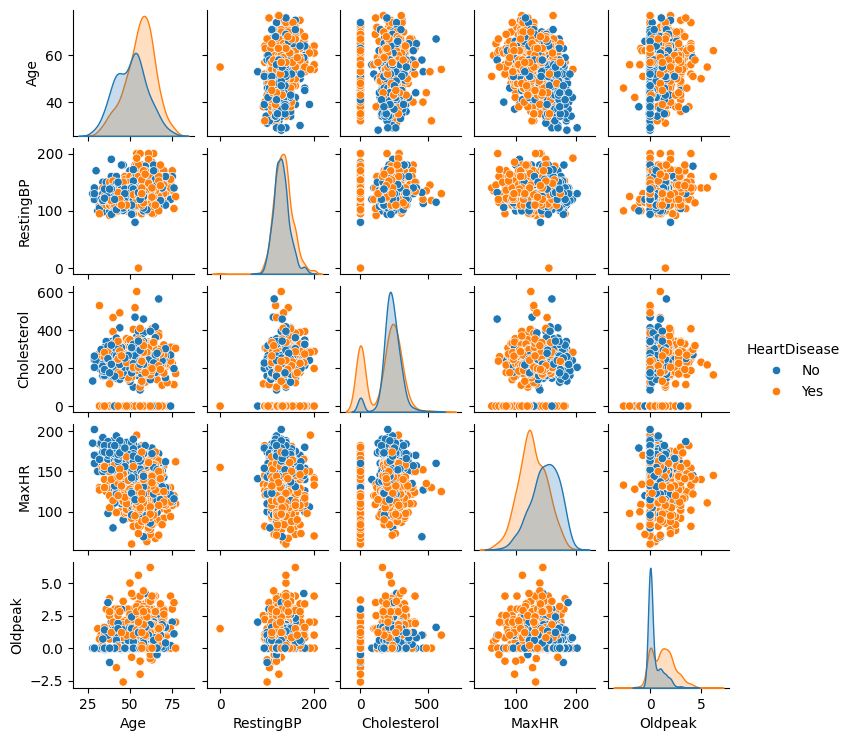

In [ ]:
import seaborn as sns

hd_cat = df["HeartDisease"].replace({"No": 0, "Yes": 1})

sns.pairplot(data=df[numerical_features + ["HeartDisease"]], hue="HeartDisease", height=1.5)


### Categorical dengan HeartDisease

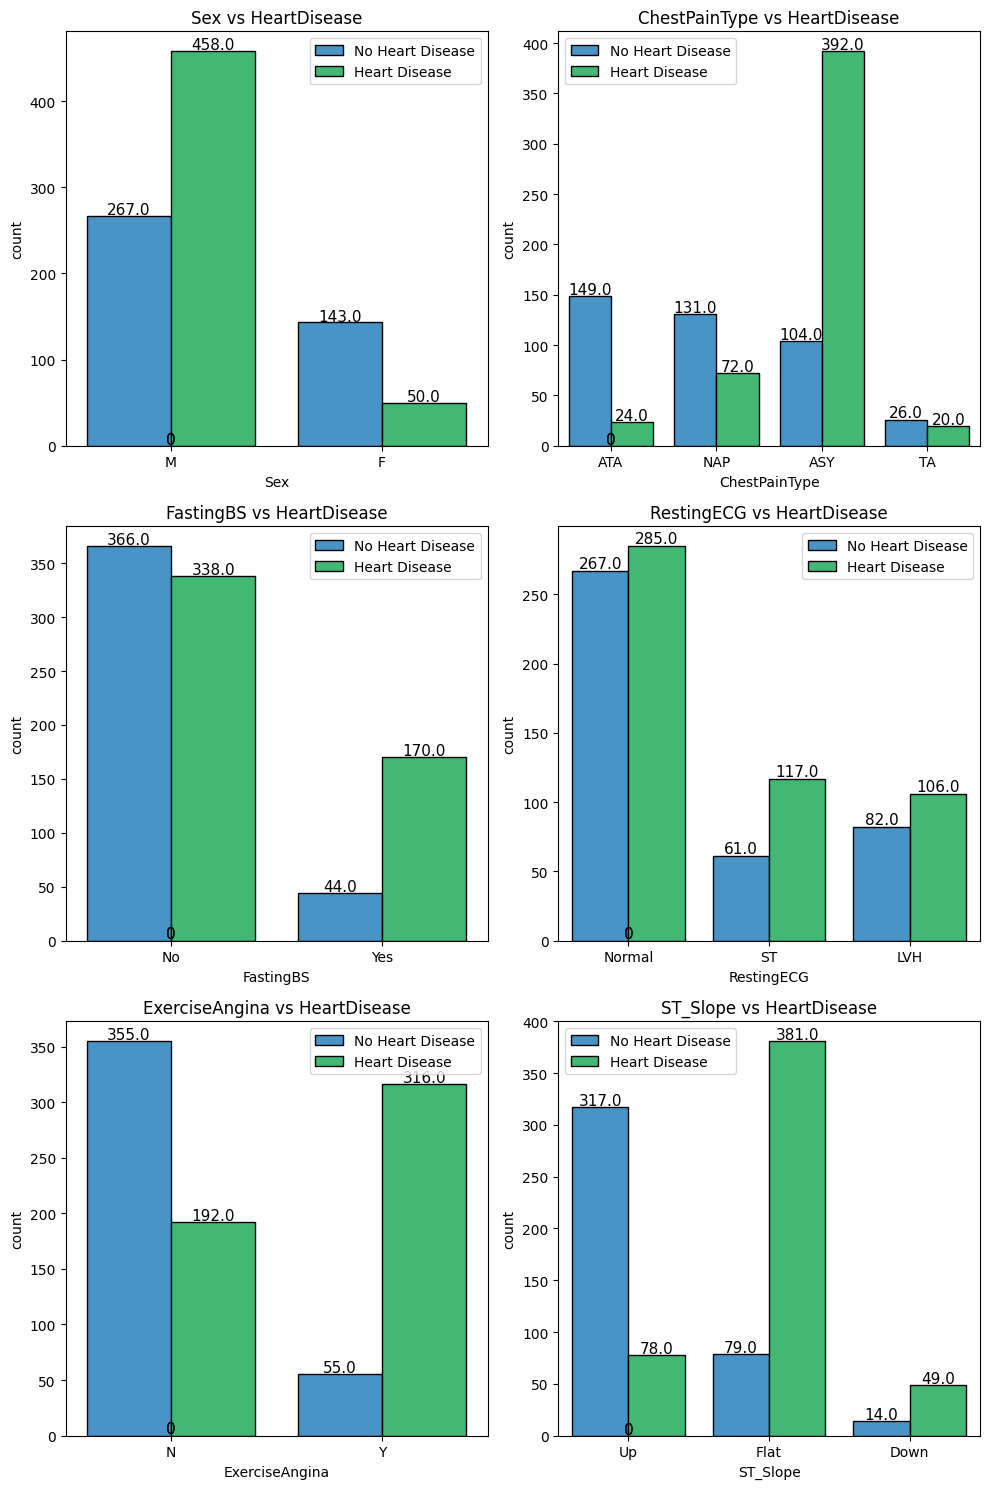

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

for i, feature in enumerate(categorical_features[:-1]):
    row = i // 2
    col = i % 2

    ax = sns.countplot(x=feature, data=df, hue="HeartDisease", palette=palette2, edgecolor='black', ax=axes[row, col])

    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)

    title = f"{feature} vs HeartDisease"
    ax.set_title(title)
    ax.legend(['No Heart Disease', 'Heart Disease'])

plt.tight_layout()
plt.show()


# Preprocessing

## transformasi data

In [ ]:
def box_cox_transform(df):
    transformed_df = df.copy()
    features_to_transform = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

    for feature in features_to_transform:
        if np.any(transformed_df[feature] <= 0):
            min_value = abs(transformed_df[feature].min()) + 1
            transformed_df[feature] += min_value
        transformed_feature, lambda_value = boxcox(transformed_df[feature])
        transformed_df[feature] = transformed_feature

    return transformed_df

In [ ]:
df = box_cox_transform(df)

## Encoding

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,110.757179,M,ATA,181.278829,88.227464,No,Normal,459.977471,N,1.167044,Up,No
1,146.240510,F,NAP,208.911449,61.859498,No,Normal,407.754118,N,1.366280,Flat,Yes
2,99.529028,M,ATA,167.554936,86.852971,No,ST,229.613126,N,1.167044,Up,No
3,142.171709,F,ASY,178.528883,70.442172,No,Normal,258.914350,Y,1.448015,Flat,Yes
4,167.028986,M,NAP,195.065638,65.693544,No,Normal,300.996562,N,1.167044,Up,No


In [ ]:
features_to_encode = ["ChestPainType", "RestingECG", "ST_Slope"]
encoder = ce.OneHotEncoder(cols=features_to_encode)

df = encoder.fit_transform(df)


In [ ]:
features_to_encode = ['Sex', 'FastingBS', 'ExerciseAngina', 'HeartDisease']
label_encoder = LabelEncoder()
for feature in features_to_encode:
    df[feature] = label_encoder.fit_transform(df[feature])

In [ ]:
df.head()

,Age,Sex,ChestPainType_1,ChestPainType_2,ChestPainType_3,ChestPainType_4,RestingBP,Cholesterol,FastingBS,RestingECG_1,RestingECG_2,RestingECG_3,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_1,ST_Slope_2,ST_Slope_3,HeartDisease
0,110.757179,1,1,0,0,0,181.278829,88.227464,0,1,0,0,459.977471,0,1.167044,1,0,0,0
1,146.240510,0,0,1,0,0,208.911449,61.859498,0,1,0,0,407.754118,0,1.366280,0,1,0,1
2,99.529028,1,1,0,0,0,167.554936,86.852971,0,0,1,0,229.613126,0,1.167044,1,0,0,0
3,142.171709,0,0,0,1,0,178.528883,70.442172,0,1,0,0,258.914350,1,1.448015,0,1,0,1
4,167.028986,1,0,1,0,0,195.065638,65.693544,0,1,0,0,300.996562,0,1.167044,1,0,0,0


# Modelling

## Split dataset

In [ ]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((734, 18), (184, 18))

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Prediction

### XGBoost

In [ ]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10)
    }

    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return 1 - f1

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best parameters:", best_params)

best_clf = xgb.XGBClassifier(**best_params)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Akurasi: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


[I 2024-05-05 14:13:04,732] A new study created in memory with name: no-name-4f53c987-e787-487b-878f-ddaf0bf96247
[I 2024-05-05 14:13:05,706] Trial 0 finished with value: 0.12380952380952392 and parameters: {'n_estimators': 468, 'max_depth': 9, 'learning_rate': 0.002928961502970497, 'subsample': 0.7671805393778003, 'colsample_bytree': 0.6426446190645771, 'gamma': 6.191552994065792, 'min_child_weight': 5.790650385878097}. Best is trial 0 with value: 0.12380952380952392.
[I 2024-05-05 14:13:07,314] Trial 1 finished with value: 0.11538461538461542 and parameters: {'n_estimators': 785, 'max_depth': 30, 'learning_rate': 0.0825067459472545, 'subsample': 0.5831191936535787, 'colsample_bytree': 0.7526691747530943, 'gamma': 8.426080683893865, 'min_child_weight': 5.920327190993155}. Best is trial 1 with value: 0.11538461538461542.
[I 2024-05-05 14:13:08,202] Trial 2 finished with value: 0.09952606635071093 and parameters: {'n_estimators': 75, 'max_depth': 30, 'learning_rate': 0.0471698324048204,

Best parameters: {'n_estimators': 733, 'max_depth': 20, 'learning_rate': 0.0104736382699905, 'subsample': 0.757650045495194, 'colsample_bytree': 0.5659918900018537, 'gamma': 8.905117517293728, 'min_child_weight': 3.032967382461151}
Akurasi: 89.13%
Precision: 0.9142857142857143
Recall: 0.897196261682243
F1-score: 0.9056603773584906


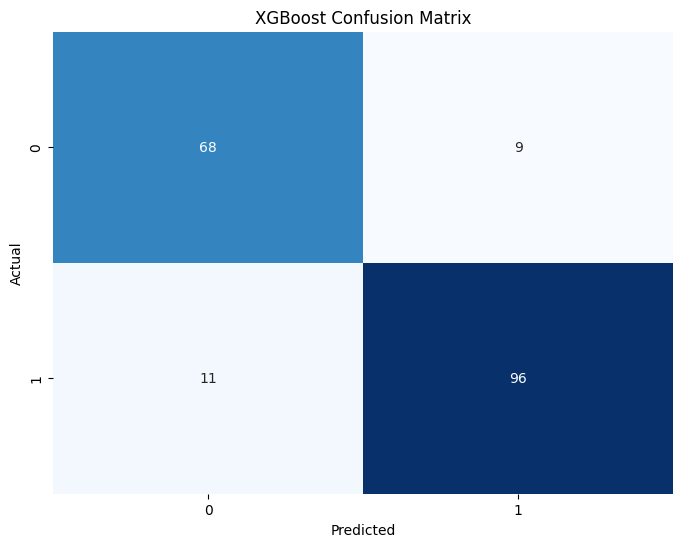

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Catboost

In [ ]:
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),  # Ubah rentang iterasi sesuai kebutuhan
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.001, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.001, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }

    clf = CatBoostClassifier(**params)

    clf.fit(X, y)

    y_pred = clf.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Return F1-score as the objective value to maximize
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

best_clf = CatBoostClassifier(**best_params)
best_clf.fit(X, y)

y_pred = best_clf.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


[I 2024-05-05 14:20:50,150] A new study created in memory with name: no-name-564aaf90-b16f-4ffa-b310-bba94a9ecf3d


0:	learn: 0.6904670	total: 18.9ms	remaining: 5.17s
1:	learn: 0.6877887	total: 42.6ms	remaining: 5.8s
2:	learn: 0.6850235	total: 72.4ms	remaining: 6.54s
3:	learn: 0.6824116	total: 104ms	remaining: 6.99s
4:	learn: 0.6794335	total: 130ms	remaining: 7.01s
5:	learn: 0.6771906	total: 154ms	remaining: 6.9s
6:	learn: 0.6745434	total: 181ms	remaining: 6.89s
7:	learn: 0.6717912	total: 204ms	remaining: 6.77s
8:	learn: 0.6691508	total: 225ms	remaining: 6.62s
9:	learn: 0.6659988	total: 239ms	remaining: 6.3s
10:	learn: 0.6630577	total: 255ms	remaining: 6.1s
11:	learn: 0.6604654	total: 269ms	remaining: 5.87s
12:	learn: 0.6579507	total: 284ms	remaining: 5.71s
13:	learn: 0.6555373	total: 303ms	remaining: 5.62s
14:	learn: 0.6528424	total: 324ms	remaining: 5.59s
15:	learn: 0.6502077	total: 337ms	remaining: 5.43s
16:	learn: 0.6477542	total: 347ms	remaining: 5.24s
17:	learn: 0.6451079	total: 360ms	remaining: 5.12s
18:	learn: 0.6425796	total: 379ms	remaining: 5.08s
19:	learn: 0.6399274	total: 405ms	remainin

[I 2024-05-05 14:20:54,763] Trial 0 finished with value: 0.8545454545454546 and parameters: {'iterations': 274, 'learning_rate': 0.0018076128448217229, 'depth': 7, 'l2_leaf_reg': 0.5684280507379499, 'border_count': 229, 'random_strength': 2.4232508398208184e-05, 'bagging_temperature': 0.004551082120251387, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.8545454545454546.


0:	learn: 0.6458931	total: 19.7ms	remaining: 9.7s
1:	learn: 0.6003639	total: 43.5ms	remaining: 10.7s
2:	learn: 0.5612017	total: 68.1ms	remaining: 11.1s
3:	learn: 0.5164531	total: 96.1ms	remaining: 11.8s
4:	learn: 0.4819635	total: 122ms	remaining: 12s
5:	learn: 0.4491491	total: 150ms	remaining: 12.2s
6:	learn: 0.4199833	total: 182ms	remaining: 12.7s
7:	learn: 0.3892715	total: 207ms	remaining: 12.6s
8:	learn: 0.3586954	total: 245ms	remaining: 13.2s
9:	learn: 0.3325670	total: 269ms	remaining: 13s
10:	learn: 0.3085185	total: 295ms	remaining: 13s
11:	learn: 0.2872876	total: 319ms	remaining: 12.8s
12:	learn: 0.2648607	total: 344ms	remaining: 12.7s
13:	learn: 0.2486557	total: 368ms	remaining: 12.6s
14:	learn: 0.2305401	total: 393ms	remaining: 12.6s
15:	learn: 0.2131917	total: 418ms	remaining: 12.5s
16:	learn: 0.2014510	total: 452ms	remaining: 12.7s
17:	learn: 0.1903461	total: 478ms	remaining: 12.6s
18:	learn: 0.1792443	total: 492ms	remaining: 12.3s
19:	learn: 0.1689682	total: 503ms	remaining:

[I 2024-05-05 14:21:01,386] Trial 1 finished with value: 0.8598130841121495 and parameters: {'iterations': 494, 'learning_rate': 0.02528767261804869, 'depth': 8, 'l2_leaf_reg': 0.044242706240147305, 'border_count': 48, 'random_strength': 1.3750403980215612e-05, 'bagging_temperature': 0.49764843574604034, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6625609	total: 2.55ms	remaining: 1.08s
1:	learn: 0.6359509	total: 5.89ms	remaining: 1.25s
2:	learn: 0.6103699	total: 8.77ms	remaining: 1.24s
3:	learn: 0.5882678	total: 11.4ms	remaining: 1.21s
4:	learn: 0.5666173	total: 14.2ms	remaining: 1.19s
5:	learn: 0.5450810	total: 17.2ms	remaining: 1.21s
6:	learn: 0.5261918	total: 20.3ms	remaining: 1.21s
7:	learn: 0.5084246	total: 23.2ms	remaining: 1.21s
8:	learn: 0.4918210	total: 25.9ms	remaining: 1.2s
9:	learn: 0.4762740	total: 28.5ms	remaining: 1.18s
10:	learn: 0.4617097	total: 31.1ms	remaining: 1.17s
11:	learn: 0.4469136	total: 33.7ms	remaining: 1.16s
12:	learn: 0.4342275	total: 36.2ms	remaining: 1.15s
13:	learn: 0.4214476	total: 39ms	remaining: 1.15s
14:	learn: 0.4107376	total: 41.6ms	remaining: 1.14s
15:	learn: 0.3997449	total: 44.2ms	remaining: 1.13s
16:	learn: 0.3889465	total: 47.3ms	remaining: 1.14s
17:	learn: 0.3786008	total: 49.9ms	remaining: 1.13s
18:	learn: 0.3694859	total: 53.1ms	remaining: 1.14s
19:	learn: 0.3584180	tota

[I 2024-05-05 14:21:03,221] Trial 2 finished with value: 0.7052023121387284 and parameters: {'iterations': 426, 'learning_rate': 0.02600568087970781, 'depth': 5, 'l2_leaf_reg': 1.2723563202693855, 'border_count': 126, 'random_strength': 0.006248146262866799, 'bagging_temperature': 0.09113908262309264, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


414:	learn: 0.0340659	total: 1.5s	remaining: 39.9ms
415:	learn: 0.0339609	total: 1.51s	remaining: 36.3ms
416:	learn: 0.0338050	total: 1.52s	remaining: 32.8ms
417:	learn: 0.0337451	total: 1.52s	remaining: 29.2ms
418:	learn: 0.0335441	total: 1.53s	remaining: 25.6ms
419:	learn: 0.0334037	total: 1.54s	remaining: 22ms
420:	learn: 0.0332558	total: 1.54s	remaining: 18.3ms
421:	learn: 0.0331674	total: 1.55s	remaining: 14.7ms
422:	learn: 0.0330544	total: 1.56s	remaining: 11.1ms
423:	learn: 0.0329152	total: 1.56s	remaining: 7.38ms
424:	learn: 0.0327755	total: 1.57s	remaining: 3.7ms
425:	learn: 0.0327174	total: 1.58s	remaining: 0us
0:	learn: 0.6806114	total: 3.1ms	remaining: 570ms
1:	learn: 0.6685781	total: 7.59ms	remaining: 694ms
2:	learn: 0.6569459	total: 13.9ms	remaining: 846ms
3:	learn: 0.6457436	total: 19.7ms	remaining: 890ms
4:	learn: 0.6348620	total: 25.5ms	remaining: 919ms
5:	learn: 0.6244019	total: 38ms	remaining: 1.13s
6:	learn: 0.6140972	total: 44.8ms	remaining: 1.14s
7:	learn: 0.60440

[I 2024-05-05 14:21:04,383] Trial 3 finished with value: 0.6896551724137931 and parameters: {'iterations': 185, 'learning_rate': 0.0185044106208407, 'depth': 7, 'l2_leaf_reg': 0.0067180131344013036, 'border_count': 188, 'random_strength': 5.123576959823413e-05, 'bagging_temperature': 0.2115768879561858, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


179:	learn: 0.1670705	total: 937ms	remaining: 26ms
180:	learn: 0.1664989	total: 943ms	remaining: 20.8ms
181:	learn: 0.1655388	total: 949ms	remaining: 15.6ms
182:	learn: 0.1648453	total: 954ms	remaining: 10.4ms
183:	learn: 0.1639198	total: 962ms	remaining: 5.23ms
184:	learn: 0.1634419	total: 967ms	remaining: 0us
0:	learn: 0.6852367	total: 10ms	remaining: 4.88s
1:	learn: 0.6776826	total: 23.5ms	remaining: 5.72s
2:	learn: 0.6708323	total: 28.5ms	remaining: 4.61s
3:	learn: 0.6631714	total: 34.1ms	remaining: 4.13s
4:	learn: 0.6557636	total: 45.2ms	remaining: 4.37s
5:	learn: 0.6493563	total: 54ms	remaining: 4.34s
6:	learn: 0.6417265	total: 67.1ms	remaining: 4.61s
7:	learn: 0.6350787	total: 74.7ms	remaining: 4.48s
8:	learn: 0.6275553	total: 86.4ms	remaining: 4.6s
9:	learn: 0.6201226	total: 94.8ms	remaining: 4.53s
10:	learn: 0.6141014	total: 104ms	remaining: 4.5s
11:	learn: 0.6071195	total: 116ms	remaining: 4.61s
12:	learn: 0.6012413	total: 123ms	remaining: 4.51s
13:	learn: 0.5946166	total: 13

[I 2024-05-05 14:21:06,712] Trial 4 finished with value: 0.8285714285714285 and parameters: {'iterations': 488, 'learning_rate': 0.0066814624188730855, 'depth': 8, 'l2_leaf_reg': 0.00578912856483295, 'border_count': 89, 'random_strength': 4.7216538206511466e-05, 'bagging_temperature': 0.44116132654706325, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


474:	learn: 0.0473387	total: 2.07s	remaining: 56.6ms
475:	learn: 0.0471880	total: 2.07s	remaining: 52.3ms
476:	learn: 0.0469717	total: 2.08s	remaining: 47.9ms
477:	learn: 0.0468375	total: 2.08s	remaining: 43.5ms
478:	learn: 0.0466764	total: 2.08s	remaining: 39.2ms
479:	learn: 0.0465335	total: 2.09s	remaining: 34.8ms
480:	learn: 0.0463720	total: 2.09s	remaining: 30.4ms
481:	learn: 0.0462091	total: 2.1s	remaining: 26.1ms
482:	learn: 0.0459808	total: 2.1s	remaining: 21.7ms
483:	learn: 0.0457781	total: 2.1s	remaining: 17.4ms
484:	learn: 0.0455455	total: 2.1s	remaining: 13ms
485:	learn: 0.0453599	total: 2.11s	remaining: 8.68ms
486:	learn: 0.0451390	total: 2.11s	remaining: 4.34ms
487:	learn: 0.0450032	total: 2.12s	remaining: 0us
0:	learn: 0.6821766	total: 3.31ms	remaining: 908ms
1:	learn: 0.6699477	total: 6.99ms	remaining: 955ms
2:	learn: 0.6592602	total: 10.7ms	remaining: 969ms
3:	learn: 0.6486847	total: 14ms	remaining: 946ms
4:	learn: 0.6380896	total: 17.5ms	remaining: 944ms
5:	learn: 0.62

[I 2024-05-05 14:21:07,877] Trial 5 finished with value: 0.5170068027210885 and parameters: {'iterations': 275, 'learning_rate': 0.010353470893306614, 'depth': 6, 'l2_leaf_reg': 5.803895656955367, 'border_count': 197, 'random_strength': 0.0875090138719664, 'bagging_temperature': 0.07370375505311483, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6900403	total: 2.42ms	remaining: 1.13s
1:	learn: 0.6869148	total: 4.78ms	remaining: 1.11s
2:	learn: 0.6839640	total: 6.25ms	remaining: 970ms
3:	learn: 0.6813067	total: 8.85ms	remaining: 1.03s
4:	learn: 0.6779711	total: 11.4ms	remaining: 1.06s
5:	learn: 0.6748099	total: 14ms	remaining: 1.07s
6:	learn: 0.6721056	total: 16.5ms	remaining: 1.09s
7:	learn: 0.6687511	total: 19ms	remaining: 1.09s
8:	learn: 0.6658637	total: 21.5ms	remaining: 1.09s
9:	learn: 0.6640605	total: 24.3ms	remaining: 1.11s
10:	learn: 0.6610062	total: 27.5ms	remaining: 1.14s
11:	learn: 0.6578221	total: 29.7ms	remaining: 1.13s
12:	learn: 0.6549794	total: 32ms	remaining: 1.12s
13:	learn: 0.6522759	total: 33.2ms	remaining: 1.08s
14:	learn: 0.6497921	total: 35.7ms	remaining: 1.08s
15:	learn: 0.6473432	total: 38.1ms	remaining: 1.08s
16:	learn: 0.6453663	total: 40.6ms	remaining: 1.08s
17:	learn: 0.6423609	total: 43.3ms	remaining: 1.08s
18:	learn: 0.6401750	total: 45.3ms	remaining: 1.07s
19:	learn: 0.6374711	total: 

[I 2024-05-05 14:21:09,257] Trial 6 finished with value: 0.7403314917127072 and parameters: {'iterations': 468, 'learning_rate': 0.004074634469773004, 'depth': 7, 'l2_leaf_reg': 7.381466766436864, 'border_count': 152, 'random_strength': 2.824243318389754, 'bagging_temperature': 0.002246972130222205, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


435:	learn: 0.3122105	total: 1.14s	remaining: 83.5ms
436:	learn: 0.3120056	total: 1.14s	remaining: 80.9ms
437:	learn: 0.3118770	total: 1.14s	remaining: 78.2ms
438:	learn: 0.3116650	total: 1.14s	remaining: 75.6ms
439:	learn: 0.3115373	total: 1.15s	remaining: 73ms
440:	learn: 0.3113413	total: 1.15s	remaining: 70.4ms
441:	learn: 0.3110743	total: 1.15s	remaining: 67.8ms
442:	learn: 0.3108172	total: 1.16s	remaining: 65.2ms
443:	learn: 0.3105918	total: 1.16s	remaining: 62.6ms
444:	learn: 0.3103020	total: 1.16s	remaining: 60ms
445:	learn: 0.3101423	total: 1.16s	remaining: 57.3ms
446:	learn: 0.3098522	total: 1.16s	remaining: 54.7ms
447:	learn: 0.3096490	total: 1.17s	remaining: 52.1ms
448:	learn: 0.3095307	total: 1.17s	remaining: 49.5ms
449:	learn: 0.3091877	total: 1.17s	remaining: 46.9ms
450:	learn: 0.3090196	total: 1.17s	remaining: 44.3ms
451:	learn: 0.3089527	total: 1.18s	remaining: 41.6ms
452:	learn: 0.3086054	total: 1.18s	remaining: 39ms
453:	learn: 0.3084494	total: 1.18s	remaining: 36.4ms

[I 2024-05-05 14:21:10,594] Trial 7 finished with value: 0.7329842931937172 and parameters: {'iterations': 194, 'learning_rate': 0.057449084396560345, 'depth': 10, 'l2_leaf_reg': 0.3933600862258292, 'border_count': 251, 'random_strength': 1.1063577776923496e-05, 'bagging_temperature': 0.12266537268913184, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


161:	learn: 0.0568436	total: 1.04s	remaining: 206ms
162:	learn: 0.0563824	total: 1.06s	remaining: 201ms
163:	learn: 0.0560037	total: 1.07s	remaining: 195ms
164:	learn: 0.0556950	total: 1.08s	remaining: 190ms
165:	learn: 0.0552671	total: 1.09s	remaining: 183ms
166:	learn: 0.0548517	total: 1.09s	remaining: 177ms
167:	learn: 0.0543046	total: 1.1s	remaining: 170ms
168:	learn: 0.0540025	total: 1.1s	remaining: 163ms
169:	learn: 0.0535661	total: 1.11s	remaining: 156ms
170:	learn: 0.0531075	total: 1.11s	remaining: 149ms
171:	learn: 0.0527558	total: 1.11s	remaining: 142ms
172:	learn: 0.0526374	total: 1.12s	remaining: 136ms
173:	learn: 0.0522873	total: 1.12s	remaining: 129ms
174:	learn: 0.0520025	total: 1.12s	remaining: 122ms
175:	learn: 0.0516448	total: 1.13s	remaining: 115ms
176:	learn: 0.0514148	total: 1.13s	remaining: 109ms
177:	learn: 0.0509866	total: 1.13s	remaining: 102ms
178:	learn: 0.0505899	total: 1.14s	remaining: 95.3ms
179:	learn: 0.0502683	total: 1.14s	remaining: 88.7ms
180:	learn: 

[I 2024-05-05 14:21:14,821] Trial 8 finished with value: 0.8518518518518519 and parameters: {'iterations': 453, 'learning_rate': 0.0027769706067696867, 'depth': 8, 'l2_leaf_reg': 1.8322702570043017, 'border_count': 171, 'random_strength': 0.10639446051733194, 'bagging_temperature': 0.1302583829820079, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


445:	learn: 0.1254309	total: 3.91s	remaining: 61.4ms
446:	learn: 0.1251941	total: 3.92s	remaining: 52.7ms
447:	learn: 0.1249911	total: 3.93s	remaining: 43.9ms
448:	learn: 0.1247231	total: 3.94s	remaining: 35.1ms
449:	learn: 0.1244588	total: 3.95s	remaining: 26.3ms
450:	learn: 0.1241566	total: 3.95s	remaining: 17.5ms
451:	learn: 0.1239550	total: 3.96s	remaining: 8.77ms
452:	learn: 0.1236214	total: 3.97s	remaining: 0us
0:	learn: 0.6920802	total: 2.67ms	remaining: 525ms
1:	learn: 0.6910630	total: 6.06ms	remaining: 594ms
2:	learn: 0.6899389	total: 8.19ms	remaining: 533ms
3:	learn: 0.6888245	total: 12ms	remaining: 581ms
4:	learn: 0.6877081	total: 15.4ms	remaining: 596ms
5:	learn: 0.6865837	total: 19.5ms	remaining: 624ms
6:	learn: 0.6854763	total: 21.6ms	remaining: 590ms
7:	learn: 0.6843768	total: 23.8ms	remaining: 565ms
8:	learn: 0.6833386	total: 26.1ms	remaining: 547ms
9:	learn: 0.6823753	total: 27.5ms	remaining: 516ms
10:	learn: 0.6814952	total: 28.4ms	remaining: 482ms
11:	learn: 0.680448

[I 2024-05-05 14:21:15,580] Trial 9 finished with value: 0.8177339901477833 and parameters: {'iterations': 198, 'learning_rate': 0.0018344806669272399, 'depth': 7, 'l2_leaf_reg': 0.011755110144449897, 'border_count': 145, 'random_strength': 0.8255413941753428, 'bagging_temperature': 0.06285510048487987, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


184:	learn: 0.5375133	total: 567ms	remaining: 39.9ms
185:	learn: 0.5367963	total: 571ms	remaining: 36.8ms
186:	learn: 0.5360870	total: 574ms	remaining: 33.8ms
187:	learn: 0.5354185	total: 577ms	remaining: 30.7ms
188:	learn: 0.5347715	total: 580ms	remaining: 27.6ms
189:	learn: 0.5341249	total: 583ms	remaining: 24.6ms
190:	learn: 0.5334973	total: 589ms	remaining: 21.6ms
191:	learn: 0.5328256	total: 594ms	remaining: 18.6ms
192:	learn: 0.5321795	total: 600ms	remaining: 15.5ms
193:	learn: 0.5315528	total: 603ms	remaining: 12.4ms
194:	learn: 0.5309428	total: 610ms	remaining: 9.39ms
195:	learn: 0.5302673	total: 615ms	remaining: 6.28ms
196:	learn: 0.5296241	total: 619ms	remaining: 3.14ms
197:	learn: 0.5289263	total: 626ms	remaining: 0us
0:	learn: 0.5353383	total: 13.4ms	remaining: 4.97s
1:	learn: 0.3986707	total: 52.9ms	remaining: 9.75s
2:	learn: 0.3053959	total: 96.3ms	remaining: 11.8s
3:	learn: 0.2341554	total: 151ms	remaining: 13.9s
4:	learn: 0.1844294	total: 205ms	remaining: 15s
5:	learn: 

[I 2024-05-05 14:21:20,980] Trial 10 finished with value: 0.7755102040816326 and parameters: {'iterations': 371, 'learning_rate': 0.0729963785082874, 'depth': 10, 'l2_leaf_reg': 0.057156958484166326, 'border_count': 33, 'random_strength': 1.371914798621893e-08, 'bagging_temperature': 0.014493418049242356, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


370:	learn: 0.0006193	total: 5.08s	remaining: 0us
0:	learn: 0.6919842	total: 1.59ms	remaining: 470ms
1:	learn: 0.6909725	total: 3.44ms	remaining: 506ms
2:	learn: 0.6899098	total: 5.16ms	remaining: 504ms
3:	learn: 0.6889447	total: 7.09ms	remaining: 518ms
4:	learn: 0.6879027	total: 8.99ms	remaining: 523ms
5:	learn: 0.6868883	total: 10.7ms	remaining: 516ms
6:	learn: 0.6858119	total: 12.5ms	remaining: 516ms
7:	learn: 0.6848408	total: 14.1ms	remaining: 509ms
8:	learn: 0.6837793	total: 16ms	remaining: 510ms
9:	learn: 0.6827862	total: 17.6ms	remaining: 504ms
10:	learn: 0.6816904	total: 19.3ms	remaining: 500ms
11:	learn: 0.6806406	total: 23ms	remaining: 544ms
12:	learn: 0.6795771	total: 25.1ms	remaining: 547ms
13:	learn: 0.6786045	total: 27.4ms	remaining: 552ms
14:	learn: 0.6775526	total: 31.5ms	remaining: 591ms
15:	learn: 0.6764667	total: 33.2ms	remaining: 582ms
16:	learn: 0.6755418	total: 34.9ms	remaining: 572ms
17:	learn: 0.6744787	total: 36.5ms	remaining: 564ms
18:	learn: 0.6734320	total: 

[I 2024-05-05 14:21:21,641] Trial 11 finished with value: 0.49673202614379086 and parameters: {'iterations': 296, 'learning_rate': 0.001044794494810547, 'depth': 4, 'l2_leaf_reg': 0.08746605021894283, 'border_count': 251, 'random_strength': 3.9673142886071213e-07, 'bagging_temperature': 0.011725109678831164, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


220:	learn: 0.5156164	total: 394ms	remaining: 134ms
221:	learn: 0.5150274	total: 396ms	remaining: 132ms
222:	learn: 0.5144989	total: 400ms	remaining: 131ms
223:	learn: 0.5139361	total: 404ms	remaining: 130ms
224:	learn: 0.5133539	total: 406ms	remaining: 128ms
225:	learn: 0.5127644	total: 408ms	remaining: 126ms
226:	learn: 0.5121959	total: 409ms	remaining: 124ms
227:	learn: 0.5116423	total: 411ms	remaining: 123ms
228:	learn: 0.5110807	total: 413ms	remaining: 121ms
229:	learn: 0.5104800	total: 415ms	remaining: 119ms
230:	learn: 0.5099528	total: 416ms	remaining: 117ms
231:	learn: 0.5094071	total: 418ms	remaining: 115ms
232:	learn: 0.5087961	total: 420ms	remaining: 113ms
233:	learn: 0.5081941	total: 422ms	remaining: 112ms
234:	learn: 0.5076199	total: 423ms	remaining: 110ms
235:	learn: 0.5070709	total: 425ms	remaining: 108ms
236:	learn: 0.5065216	total: 427ms	remaining: 106ms
237:	learn: 0.5059017	total: 428ms	remaining: 104ms
238:	learn: 0.5053694	total: 430ms	remaining: 103ms
239:	learn: 

[I 2024-05-05 14:21:25,523] Trial 12 finished with value: 0.8454545454545455 and parameters: {'iterations': 360, 'learning_rate': 0.027381936179983093, 'depth': 9, 'l2_leaf_reg': 0.2582438400505128, 'border_count': 39, 'random_strength': 0.0013037393654529404, 'bagging_temperature': 0.9674203285958477, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6837584	total: 7.07ms	remaining: 806ms
1:	learn: 0.6743846	total: 14.9ms	remaining: 840ms
2:	learn: 0.6650766	total: 22.6ms	remaining: 843ms
3:	learn: 0.6555440	total: 30.8ms	remaining: 855ms
4:	learn: 0.6465532	total: 40.3ms	remaining: 886ms
5:	learn: 0.6377677	total: 48ms	remaining: 872ms
6:	learn: 0.6290901	total: 56.9ms	remaining: 878ms
7:	learn: 0.6207064	total: 65.4ms	remaining: 875ms
8:	learn: 0.6122344	total: 73.7ms	remaining: 868ms
9:	learn: 0.6045935	total: 81.3ms	remaining: 854ms
10:	learn: 0.5967203	total: 89.7ms	remaining: 849ms
11:	learn: 0.5890124	total: 98.1ms	remaining: 842ms
12:	learn: 0.5812332	total: 106ms	remaining: 833ms
13:	learn: 0.5737430	total: 114ms	remaining: 824ms
14:	learn: 0.5663589	total: 123ms	remaining: 819ms
15:	learn: 0.5592547	total: 130ms	remaining: 807ms
16:	learn: 0.5522565	total: 139ms	remaining: 799ms
17:	learn: 0.5454211	total: 147ms	remaining: 792ms
18:	learn: 0.5387625	total: 155ms	remaining: 782ms
19:	learn: 0.5321821	total: 164

[I 2024-05-05 14:21:26,676] Trial 13 finished with value: 0.8571428571428571 and parameters: {'iterations': 115, 'learning_rate': 0.01203467974303711, 'depth': 8, 'l2_leaf_reg': 0.0013825658932843786, 'border_count': 88, 'random_strength': 5.811366264139452e-07, 'bagging_temperature': 0.0012196106350627568, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6837861	total: 6.39ms	remaining: 747ms
1:	learn: 0.6739816	total: 15.4ms	remaining: 893ms
2:	learn: 0.6648125	total: 23.9ms	remaining: 916ms
3:	learn: 0.6554803	total: 33.5ms	remaining: 955ms
4:	learn: 0.6464021	total: 44.1ms	remaining: 996ms
5:	learn: 0.6374821	total: 55ms	remaining: 1.03s
6:	learn: 0.6285679	total: 65.7ms	remaining: 1.04s
7:	learn: 0.6199263	total: 75.5ms	remaining: 1.04s
8:	learn: 0.6114162	total: 86.7ms	remaining: 1.05s
9:	learn: 0.6030619	total: 99.3ms	remaining: 1.07s
10:	learn: 0.5946992	total: 110ms	remaining: 1.07s
11:	learn: 0.5865619	total: 120ms	remaining: 1.06s
12:	learn: 0.5788595	total: 130ms	remaining: 1.05s
13:	learn: 0.5713773	total: 139ms	remaining: 1.03s
14:	learn: 0.5640611	total: 151ms	remaining: 1.03s
15:	learn: 0.5566874	total: 161ms	remaining: 1.03s
16:	learn: 0.5493427	total: 182ms	remaining: 1.08s
17:	learn: 0.5423076	total: 209ms	remaining: 1.16s
18:	learn: 0.5354965	total: 220ms	remaining: 1.14s
19:	learn: 0.5286419	total: 230ms

[I 2024-05-05 14:21:28,335] Trial 14 finished with value: 0.838709677419355 and parameters: {'iterations': 118, 'learning_rate': 0.011749431319122528, 'depth': 9, 'l2_leaf_reg': 0.0010456922821257008, 'border_count': 79, 'random_strength': 1.279210409640049e-09, 'bagging_temperature': 0.001377980733290223, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


114:	learn: 0.1839679	total: 1.46s	remaining: 38ms
115:	learn: 0.1821708	total: 1.47s	remaining: 25.4ms
116:	learn: 0.1801836	total: 1.49s	remaining: 12.7ms
117:	learn: 0.1784060	total: 1.51s	remaining: 0us
0:	learn: 0.6169760	total: 17.5ms	remaining: 6.66s
1:	learn: 0.5494005	total: 35.2ms	remaining: 6.68s
2:	learn: 0.4787388	total: 64.9ms	remaining: 8.2s
3:	learn: 0.4308311	total: 86.7ms	remaining: 8.19s
4:	learn: 0.3824377	total: 112ms	remaining: 8.48s
5:	learn: 0.3488411	total: 136ms	remaining: 8.55s
6:	learn: 0.3096176	total: 160ms	remaining: 8.57s
7:	learn: 0.2832715	total: 183ms	remaining: 8.55s
8:	learn: 0.2571427	total: 222ms	remaining: 9.2s
9:	learn: 0.2359139	total: 249ms	remaining: 9.27s
10:	learn: 0.2084875	total: 274ms	remaining: 9.26s
11:	learn: 0.1876843	total: 299ms	remaining: 9.21s
12:	learn: 0.1721619	total: 324ms	remaining: 9.19s
13:	learn: 0.1543233	total: 348ms	remaining: 9.15s
14:	learn: 0.1385474	total: 366ms	remaining: 8.95s
15:	learn: 0.1257465	total: 394ms	re

[I 2024-05-05 14:21:32,460] Trial 15 finished with value: 0.8425925925925924 and parameters: {'iterations': 382, 'learning_rate': 0.03773742745678427, 'depth': 8, 'l2_leaf_reg': 0.02518324896065017, 'border_count': 77, 'random_strength': 2.9378233194989325e-07, 'bagging_temperature': 0.023915221597110903, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


362:	learn: 0.0004502	total: 3.72s	remaining: 195ms
363:	learn: 0.0004502	total: 3.72s	remaining: 184ms
364:	learn: 0.0004502	total: 3.73s	remaining: 174ms
365:	learn: 0.0004502	total: 3.73s	remaining: 163ms
366:	learn: 0.0004502	total: 3.74s	remaining: 153ms
367:	learn: 0.0004502	total: 3.75s	remaining: 142ms
368:	learn: 0.0004502	total: 3.75s	remaining: 132ms
369:	learn: 0.0004502	total: 3.76s	remaining: 122ms
370:	learn: 0.0004502	total: 3.76s	remaining: 112ms
371:	learn: 0.0004502	total: 3.77s	remaining: 101ms
372:	learn: 0.0004502	total: 3.78s	remaining: 91.1ms
373:	learn: 0.0004502	total: 3.78s	remaining: 80.9ms
374:	learn: 0.0004502	total: 3.79s	remaining: 70.7ms
375:	learn: 0.0004502	total: 3.79s	remaining: 60.5ms
376:	learn: 0.0004502	total: 3.8s	remaining: 50.4ms
377:	learn: 0.0004502	total: 3.8s	remaining: 40.2ms
378:	learn: 0.0004502	total: 3.81s	remaining: 30.2ms
379:	learn: 0.0004502	total: 3.81s	remaining: 20.1ms
380:	learn: 0.0004502	total: 3.82s	remaining: 10ms
381:	le

[I 2024-05-05 14:21:34,356] Trial 16 finished with value: 0.8571428571428571 and parameters: {'iterations': 115, 'learning_rate': 0.016521375258421796, 'depth': 9, 'l2_leaf_reg': 0.001116418315973529, 'border_count': 111, 'random_strength': 8.120095663311403e-07, 'bagging_temperature': 0.0046659004790011414, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


111:	learn: 0.1199265	total: 1.68s	remaining: 45ms
112:	learn: 0.1182361	total: 1.7s	remaining: 30.1ms
113:	learn: 0.1166988	total: 1.72s	remaining: 15.1ms
114:	learn: 0.1150394	total: 1.73s	remaining: 0us
0:	learn: 0.6839280	total: 3.06ms	remaining: 692ms
1:	learn: 0.6739165	total: 6.35ms	remaining: 715ms
2:	learn: 0.6643493	total: 9.57ms	remaining: 715ms
3:	learn: 0.6552370	total: 12.7ms	remaining: 706ms
4:	learn: 0.6464320	total: 15.8ms	remaining: 703ms
5:	learn: 0.6370776	total: 18.9ms	remaining: 697ms
6:	learn: 0.6271607	total: 22.3ms	remaining: 700ms
7:	learn: 0.6190886	total: 26.4ms	remaining: 724ms
8:	learn: 0.6108050	total: 32.1ms	remaining: 778ms
9:	learn: 0.6031351	total: 37.5ms	remaining: 813ms
10:	learn: 0.5952370	total: 40.4ms	remaining: 793ms
11:	learn: 0.5871612	total: 43.8ms	remaining: 785ms
12:	learn: 0.5784023	total: 47ms	remaining: 774ms
13:	learn: 0.5716772	total: 50.7ms	remaining: 771ms
14:	learn: 0.5648283	total: 53.8ms	remaining: 761ms
15:	learn: 0.5570714	total

[I 2024-05-05 14:21:35,256] Trial 17 finished with value: 0.8584474885844748 and parameters: {'iterations': 227, 'learning_rate': 0.006206819725154262, 'depth': 6, 'l2_leaf_reg': 0.003057292997058955, 'border_count': 56, 'random_strength': 3.077396990132544e-08, 'bagging_temperature': 0.3502126857277821, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


188:	learn: 0.1174519	total: 624ms	remaining: 125ms
189:	learn: 0.1168999	total: 631ms	remaining: 123ms
190:	learn: 0.1162571	total: 634ms	remaining: 120ms
191:	learn: 0.1149474	total: 637ms	remaining: 116ms
192:	learn: 0.1143133	total: 641ms	remaining: 113ms
193:	learn: 0.1136185	total: 644ms	remaining: 109ms
194:	learn: 0.1127817	total: 647ms	remaining: 106ms
195:	learn: 0.1120222	total: 650ms	remaining: 103ms
196:	learn: 0.1113997	total: 654ms	remaining: 99.5ms
197:	learn: 0.1107656	total: 657ms	remaining: 96.2ms
198:	learn: 0.1101439	total: 660ms	remaining: 92.9ms
199:	learn: 0.1091572	total: 663ms	remaining: 89.5ms
200:	learn: 0.1084120	total: 666ms	remaining: 86.2ms
201:	learn: 0.1076527	total: 670ms	remaining: 82.9ms
202:	learn: 0.1069732	total: 673ms	remaining: 79.5ms
203:	learn: 0.1061452	total: 676ms	remaining: 76.2ms
204:	learn: 0.1054052	total: 679ms	remaining: 72.9ms
205:	learn: 0.1047855	total: 682ms	remaining: 69.6ms
206:	learn: 0.1040107	total: 685ms	remaining: 66.2ms
2

[I 2024-05-05 14:21:36,230] Trial 18 finished with value: 0.8372093023255813 and parameters: {'iterations': 326, 'learning_rate': 0.005742323081041946, 'depth': 5, 'l2_leaf_reg': 0.003920093601790461, 'border_count': 58, 'random_strength': 6.11641774259792e-09, 'bagging_temperature': 0.42189470634579507, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


306:	learn: 0.1468775	total: 769ms	remaining: 47.6ms
307:	learn: 0.1463992	total: 772ms	remaining: 45.1ms
308:	learn: 0.1458897	total: 778ms	remaining: 42.8ms
309:	learn: 0.1455087	total: 781ms	remaining: 40.3ms
310:	learn: 0.1450182	total: 783ms	remaining: 37.8ms
311:	learn: 0.1445855	total: 785ms	remaining: 35.2ms
312:	learn: 0.1440415	total: 788ms	remaining: 32.7ms
313:	learn: 0.1436544	total: 790ms	remaining: 30.2ms
314:	learn: 0.1433212	total: 793ms	remaining: 27.7ms
315:	learn: 0.1425243	total: 795ms	remaining: 25.2ms
316:	learn: 0.1421693	total: 797ms	remaining: 22.6ms
317:	learn: 0.1418204	total: 800ms	remaining: 20.1ms
318:	learn: 0.1413912	total: 802ms	remaining: 17.6ms
319:	learn: 0.1409504	total: 805ms	remaining: 15.1ms
320:	learn: 0.1405511	total: 807ms	remaining: 12.6ms
321:	learn: 0.1401757	total: 809ms	remaining: 10ms
322:	learn: 0.1395871	total: 811ms	remaining: 7.53ms
323:	learn: 0.1390092	total: 813ms	remaining: 5.02ms
324:	learn: 0.1387375	total: 816ms	remaining: 2.

[I 2024-05-05 14:21:36,798] Trial 19 finished with value: 0.36363636363636365 and parameters: {'iterations': 240, 'learning_rate': 0.04599294689671366, 'depth': 6, 'l2_leaf_reg': 0.029263375827348014, 'border_count': 59, 'random_strength': 2.5822439117827318e-08, 'bagging_temperature': 0.9846518001010847, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


235:	learn: 0.0208594	total: 423ms	remaining: 7.17ms
236:	learn: 0.0206248	total: 425ms	remaining: 5.38ms
237:	learn: 0.0203222	total: 428ms	remaining: 3.59ms
238:	learn: 0.0200519	total: 430ms	remaining: 1.8ms
239:	learn: 0.0198179	total: 433ms	remaining: 0us
0:	learn: 0.6855252	total: 3.31ms	remaining: 1.37s
1:	learn: 0.6759958	total: 6.92ms	remaining: 1.43s
2:	learn: 0.6688939	total: 10.4ms	remaining: 1.43s
3:	learn: 0.6603006	total: 13.8ms	remaining: 1.41s
4:	learn: 0.6534029	total: 17.1ms	remaining: 1.4s
5:	learn: 0.6462488	total: 20.5ms	remaining: 1.4s
6:	learn: 0.6386089	total: 23.9ms	remaining: 1.39s
7:	learn: 0.6319991	total: 27.2ms	remaining: 1.38s
8:	learn: 0.6261090	total: 30.6ms	remaining: 1.38s
9:	learn: 0.6193104	total: 34.1ms	remaining: 1.38s
10:	learn: 0.6124667	total: 37.5ms	remaining: 1.38s
11:	learn: 0.6056761	total: 40.9ms	remaining: 1.37s
12:	learn: 0.5983678	total: 44.4ms	remaining: 1.37s
13:	learn: 0.5919707	total: 47.7ms	remaining: 1.37s
14:	learn: 0.5854757	to

[I 2024-05-05 14:21:38,562] Trial 20 finished with value: 0.847926267281106 and parameters: {'iterations': 415, 'learning_rate': 0.005470880986144823, 'depth': 6, 'l2_leaf_reg': 0.1884758627738113, 'border_count': 112, 'random_strength': 0.0010634803829565158, 'bagging_temperature': 0.32289964434095914, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


396:	learn: 0.0793925	total: 1.51s	remaining: 68.4ms
397:	learn: 0.0791982	total: 1.52s	remaining: 64.8ms
398:	learn: 0.0789391	total: 1.52s	remaining: 60.9ms
399:	learn: 0.0786998	total: 1.52s	remaining: 57.1ms
400:	learn: 0.0785114	total: 1.52s	remaining: 53.3ms
401:	learn: 0.0783842	total: 1.53s	remaining: 49.4ms
402:	learn: 0.0781462	total: 1.53s	remaining: 45.6ms
403:	learn: 0.0778998	total: 1.53s	remaining: 41.8ms
404:	learn: 0.0777309	total: 1.54s	remaining: 38ms
405:	learn: 0.0774419	total: 1.54s	remaining: 34.2ms
406:	learn: 0.0772867	total: 1.54s	remaining: 30.4ms
407:	learn: 0.0770790	total: 1.55s	remaining: 26.6ms
408:	learn: 0.0768304	total: 1.55s	remaining: 22.8ms
409:	learn: 0.0766398	total: 1.55s	remaining: 19ms
410:	learn: 0.0763432	total: 1.56s	remaining: 15.2ms
411:	learn: 0.0761248	total: 1.56s	remaining: 11.4ms
412:	learn: 0.0758675	total: 1.56s	remaining: 7.58ms
413:	learn: 0.0755961	total: 1.57s	remaining: 3.79ms
414:	learn: 0.0753994	total: 1.57s	remaining: 0us


[I 2024-05-05 14:21:39,997] Trial 21 finished with value: 0.8545454545454546 and parameters: {'iterations': 159, 'learning_rate': 0.013638726783233168, 'depth': 8, 'l2_leaf_reg': 0.002099380347690284, 'border_count': 57, 'random_strength': 4.064859248350365e-06, 'bagging_temperature': 0.04594857491246218, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


158:	learn: 0.1093543	total: 1.28s	remaining: 0us
0:	learn: 0.6812469	total: 2.1ms	remaining: 493ms
1:	learn: 0.6709642	total: 4.64ms	remaining: 543ms
2:	learn: 0.6596246	total: 7.29ms	remaining: 566ms
3:	learn: 0.6495738	total: 9.78ms	remaining: 567ms
4:	learn: 0.6406610	total: 12.1ms	remaining: 560ms
5:	learn: 0.6304678	total: 14.5ms	remaining: 558ms
6:	learn: 0.6206835	total: 16.9ms	remaining: 553ms
7:	learn: 0.6117366	total: 19.3ms	remaining: 549ms
8:	learn: 0.6032406	total: 21.6ms	remaining: 546ms
9:	learn: 0.5942027	total: 24.2ms	remaining: 546ms
10:	learn: 0.5860599	total: 26.8ms	remaining: 549ms
11:	learn: 0.5771251	total: 29.2ms	remaining: 544ms
12:	learn: 0.5691458	total: 31.7ms	remaining: 544ms
13:	learn: 0.5587534	total: 34ms	remaining: 539ms
14:	learn: 0.5511249	total: 36.2ms	remaining: 534ms
15:	learn: 0.5443031	total: 38.5ms	remaining: 529ms
16:	learn: 0.5371732	total: 41ms	remaining: 528ms
17:	learn: 0.5292174	total: 43.4ms	remaining: 526ms
18:	learn: 0.5212637	total: 4

[I 2024-05-05 14:21:40,919] Trial 22 finished with value: 0.847926267281106 and parameters: {'iterations': 236, 'learning_rate': 0.009101546019822626, 'depth': 5, 'l2_leaf_reg': 0.00280293465693391, 'border_count': 97, 'random_strength': 7.488803453316693e-08, 'bagging_temperature': 0.5695600719547723, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


217:	learn: 0.1258481	total: 641ms	remaining: 52.9ms
218:	learn: 0.1252766	total: 645ms	remaining: 50.1ms
219:	learn: 0.1247463	total: 650ms	remaining: 47.3ms
220:	learn: 0.1238071	total: 658ms	remaining: 44.6ms
221:	learn: 0.1231459	total: 664ms	remaining: 41.9ms
222:	learn: 0.1226264	total: 670ms	remaining: 39ms
223:	learn: 0.1219566	total: 676ms	remaining: 36.2ms
224:	learn: 0.1213103	total: 681ms	remaining: 33.3ms
225:	learn: 0.1207948	total: 687ms	remaining: 30.4ms
226:	learn: 0.1202696	total: 693ms	remaining: 27.5ms
227:	learn: 0.1197825	total: 699ms	remaining: 24.5ms
228:	learn: 0.1190389	total: 704ms	remaining: 21.5ms
229:	learn: 0.1184470	total: 710ms	remaining: 18.5ms
230:	learn: 0.1175205	total: 715ms	remaining: 15.5ms
231:	learn: 0.1167860	total: 722ms	remaining: 12.4ms
232:	learn: 0.1159565	total: 727ms	remaining: 9.36ms
233:	learn: 0.1151861	total: 732ms	remaining: 6.26ms
234:	learn: 0.1144137	total: 741ms	remaining: 3.15ms
235:	learn: 0.1139022	total: 745ms	remaining: 0u

[I 2024-05-05 14:21:42,079] Trial 23 finished with value: 0.6107784431137724 and parameters: {'iterations': 143, 'learning_rate': 0.019628899604034057, 'depth': 6, 'l2_leaf_reg': 0.016483032224553534, 'border_count': 50, 'random_strength': 2.019111251311894e-06, 'bagging_temperature': 0.1709684539141211, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6756858	total: 16.9ms	remaining: 3.98s
1:	learn: 0.6551901	total: 39.1ms	remaining: 4.58s
2:	learn: 0.6364850	total: 72.5ms	remaining: 5.63s
3:	learn: 0.6170316	total: 119ms	remaining: 6.88s
4:	learn: 0.5965865	total: 160ms	remaining: 7.38s
5:	learn: 0.5812485	total: 180ms	remaining: 6.9s
6:	learn: 0.5620609	total: 199ms	remaining: 6.51s
7:	learn: 0.5421723	total: 228ms	remaining: 6.5s
8:	learn: 0.5250904	total: 252ms	remaining: 6.36s
9:	learn: 0.5115942	total: 282ms	remaining: 6.38s
10:	learn: 0.4956178	total: 314ms	remaining: 6.43s
11:	learn: 0.4826257	total: 339ms	remaining: 6.32s
12:	learn: 0.4669770	total: 369ms	remaining: 6.33s
13:	learn: 0.4545047	total: 410ms	remaining: 6.5s
14:	learn: 0.4437702	total: 456ms	remaining: 6.72s
15:	learn: 0.4317330	total: 474ms	remaining: 6.51s
16:	learn: 0.4208232	total: 496ms	remaining: 6.39s
17:	learn: 0.4081922	total: 533ms	remaining: 6.46s
18:	learn: 0.3973144	total: 568ms	remaining: 6.49s
19:	learn: 0.3881531	total: 601ms	remaini

[I 2024-05-05 14:21:46,395] Trial 24 finished with value: 0.7817258883248731 and parameters: {'iterations': 236, 'learning_rate': 0.007704165244090884, 'depth': 9, 'l2_leaf_reg': 0.00803603464351278, 'border_count': 73, 'random_strength': 2.0937916901037535e-07, 'bagging_temperature': 0.0010396136646828539, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6207229	total: 7.25ms	remaining: 2.33s
1:	learn: 0.5625721	total: 16ms	remaining: 2.57s
2:	learn: 0.5009572	total: 25.2ms	remaining: 2.68s
3:	learn: 0.4528571	total: 34ms	remaining: 2.7s
4:	learn: 0.4038163	total: 42.2ms	remaining: 2.67s
5:	learn: 0.3532235	total: 52ms	remaining: 2.74s
6:	learn: 0.3067988	total: 60.8ms	remaining: 2.74s
7:	learn: 0.2812572	total: 68.4ms	remaining: 2.68s
8:	learn: 0.2557776	total: 75.8ms	remaining: 2.64s
9:	learn: 0.2349880	total: 87.8ms	remaining: 2.74s
10:	learn: 0.2155228	total: 95.9ms	remaining: 2.71s
11:	learn: 0.1973198	total: 104ms	remaining: 2.68s
12:	learn: 0.1769445	total: 113ms	remaining: 2.68s
13:	learn: 0.1640133	total: 122ms	remaining: 2.69s
14:	learn: 0.1523211	total: 139ms	remaining: 2.85s
15:	learn: 0.1378618	total: 151ms	remaining: 2.89s
16:	learn: 0.1242960	total: 160ms	remaining: 2.87s
17:	learn: 0.1154373	total: 169ms	remaining: 2.85s
18:	learn: 0.1041716	total: 177ms	remaining: 2.81s
19:	learn: 0.0957826	total: 185ms	rem

[I 2024-05-05 14:21:49,819] Trial 25 finished with value: 0.8543689320388348 and parameters: {'iterations': 322, 'learning_rate': 0.03306221140130071, 'depth': 8, 'l2_leaf_reg': 0.002449620036017067, 'border_count': 102, 'random_strength': 3.393295962818677e-09, 'bagging_temperature': 0.024498361427888218, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6294072	total: 4.76ms	remaining: 752ms
1:	learn: 0.5715993	total: 10.7ms	remaining: 838ms
2:	learn: 0.5218911	total: 16.2ms	remaining: 844ms
3:	learn: 0.4787154	total: 21.7ms	remaining: 842ms
4:	learn: 0.4413675	total: 27ms	remaining: 833ms
5:	learn: 0.4080565	total: 32.8ms	remaining: 837ms
6:	learn: 0.3790517	total: 38.4ms	remaining: 834ms
7:	learn: 0.3522336	total: 44.5ms	remaining: 841ms
8:	learn: 0.3288493	total: 49.9ms	remaining: 831ms
9:	learn: 0.3068754	total: 55.5ms	remaining: 827ms
10:	learn: 0.2875261	total: 61.2ms	remaining: 823ms
11:	learn: 0.2693829	total: 66.8ms	remaining: 819ms
12:	learn: 0.2549131	total: 71.8ms	remaining: 806ms
13:	learn: 0.2390263	total: 77.4ms	remaining: 802ms
14:	learn: 0.2269597	total: 82.3ms	remaining: 790ms
15:	learn: 0.2136194	total: 87.5ms	remaining: 782ms
16:	learn: 0.2024081	total: 92.8ms	remaining: 775ms
17:	learn: 0.1920906	total: 98.2ms	remaining: 769ms
18:	learn: 0.1820353	total: 103ms	remaining: 762ms
19:	learn: 0.1727663	tota

[I 2024-05-05 14:21:50,788] Trial 26 finished with value: 0.7653061224489796 and parameters: {'iterations': 159, 'learning_rate': 0.09180147604870413, 'depth': 7, 'l2_leaf_reg': 0.03835864086289027, 'border_count': 122, 'random_strength': 0.00028740230925748667, 'bagging_temperature': 0.006252192288386816, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


152:	learn: 0.0055592	total: 811ms	remaining: 31.8ms
153:	learn: 0.0055034	total: 816ms	remaining: 26.5ms
154:	learn: 0.0054054	total: 821ms	remaining: 21.2ms
155:	learn: 0.0053696	total: 825ms	remaining: 15.9ms
156:	learn: 0.0053153	total: 828ms	remaining: 10.6ms
157:	learn: 0.0052729	total: 832ms	remaining: 5.27ms
158:	learn: 0.0052283	total: 836ms	remaining: 0us
0:	learn: 0.6908250	total: 1.34ms	remaining: 140ms
1:	learn: 0.6885031	total: 2.69ms	remaining: 138ms
2:	learn: 0.6861697	total: 5.5ms	remaining: 187ms
3:	learn: 0.6838668	total: 10.5ms	remaining: 265ms
4:	learn: 0.6815423	total: 12.9ms	remaining: 258ms
5:	learn: 0.6792374	total: 13.8ms	remaining: 227ms
6:	learn: 0.6770130	total: 15ms	remaining: 209ms
7:	learn: 0.6747193	total: 16.1ms	remaining: 195ms
8:	learn: 0.6725659	total: 17.2ms	remaining: 183ms
9:	learn: 0.6703692	total: 18.4ms	remaining: 174ms
10:	learn: 0.6681908	total: 19.5ms	remaining: 167ms
11:	learn: 0.6660419	total: 20.6ms	remaining: 160ms
12:	learn: 0.6638238	

[I 2024-05-05 14:21:51,043] Trial 27 finished with value: 0.5064935064935064 and parameters: {'iterations': 105, 'learning_rate': 0.003837841072940757, 'depth': 4, 'l2_leaf_reg': 0.0018971742641063034, 'border_count': 44, 'random_strength': 5.083158889315516e-08, 'bagging_temperature': 0.19791643718203691, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


39:	learn: 0.6105810	total: 54.5ms	remaining: 88.6ms
40:	learn: 0.6087515	total: 55.7ms	remaining: 86.9ms
41:	learn: 0.6069429	total: 58ms	remaining: 87ms
42:	learn: 0.6051278	total: 60.7ms	remaining: 87.5ms
43:	learn: 0.6033681	total: 61.8ms	remaining: 85.7ms
44:	learn: 0.6016449	total: 63.7ms	remaining: 85ms
45:	learn: 0.5999061	total: 67.6ms	remaining: 86.8ms
46:	learn: 0.5982177	total: 68.8ms	remaining: 85ms
47:	learn: 0.5964708	total: 69.9ms	remaining: 83ms
48:	learn: 0.5948092	total: 71ms	remaining: 81.1ms
49:	learn: 0.5931056	total: 72ms	remaining: 79.2ms
50:	learn: 0.5913840	total: 73.1ms	remaining: 77.3ms
51:	learn: 0.5896835	total: 74.1ms	remaining: 75.5ms
52:	learn: 0.5879891	total: 75.1ms	remaining: 73.7ms
53:	learn: 0.5863150	total: 76.3ms	remaining: 72.1ms
54:	learn: 0.5846770	total: 77.4ms	remaining: 70.4ms
55:	learn: 0.5830307	total: 78.5ms	remaining: 68.7ms
56:	learn: 0.5814205	total: 79.5ms	remaining: 67ms
57:	learn: 0.5798202	total: 80.7ms	remaining: 65.4ms
58:	learn

[I 2024-05-05 14:21:51,983] Trial 28 finished with value: 0.81 and parameters: {'iterations': 211, 'learning_rate': 0.024066466318208253, 'depth': 8, 'l2_leaf_reg': 0.015255201643961925, 'border_count': 70, 'random_strength': 3.128322949826885e-06, 'bagging_temperature': 0.6392844347794273, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6719570	total: 2.46ms	remaining: 651ms
1:	learn: 0.6508529	total: 5.3ms	remaining: 700ms
2:	learn: 0.6309142	total: 8.07ms	remaining: 707ms
3:	learn: 0.6138543	total: 10.6ms	remaining: 692ms
4:	learn: 0.5971738	total: 13.2ms	remaining: 687ms
5:	learn: 0.5798505	total: 15.7ms	remaining: 679ms
6:	learn: 0.5640215	total: 18.1ms	remaining: 671ms
7:	learn: 0.5497583	total: 20.6ms	remaining: 664ms
8:	learn: 0.5357744	total: 23ms	remaining: 657ms
9:	learn: 0.5217620	total: 25.3ms	remaining: 649ms
10:	learn: 0.5093195	total: 28.5ms	remaining: 661ms
11:	learn: 0.4970324	total: 31.1ms	remaining: 657ms
12:	learn: 0.4859212	total: 33.7ms	remaining: 656ms
13:	learn: 0.4744742	total: 36.7ms	remaining: 660ms
14:	learn: 0.4641210	total: 39.5ms	remaining: 661ms
15:	learn: 0.4526622	total: 42ms	remaining: 656ms
16:	learn: 0.4418063	total: 45.1ms	remaining: 661ms
17:	learn: 0.4314350	total: 47.7ms	remaining: 657ms
18:	learn: 0.4225197	total: 50.2ms	remaining: 653ms
19:	learn: 0.4136812	total:

[I 2024-05-05 14:21:52,890] Trial 29 finished with value: 0.36363636363636365 and parameters: {'iterations': 266, 'learning_rate': 0.014254686499098824, 'depth': 7, 'l2_leaf_reg': 0.12697894349965783, 'border_count': 34, 'random_strength': 1.2550829131445522e-05, 'bagging_temperature': 0.0022532738769297325, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6872380	total: 3.27ms	remaining: 1.06s
1:	learn: 0.6786670	total: 7.39ms	remaining: 1.2s
2:	learn: 0.6725036	total: 11.1ms	remaining: 1.19s
3:	learn: 0.6668965	total: 14.5ms	remaining: 1.17s
4:	learn: 0.6610426	total: 17.9ms	remaining: 1.15s
5:	learn: 0.6553350	total: 21.8ms	remaining: 1.16s
6:	learn: 0.6497729	total: 25.7ms	remaining: 1.17s
7:	learn: 0.6440003	total: 29.3ms	remaining: 1.16s
8:	learn: 0.6384506	total: 33.1ms	remaining: 1.17s
9:	learn: 0.6323286	total: 37ms	remaining: 1.17s
10:	learn: 0.6270099	total: 40.9ms	remaining: 1.17s
11:	learn: 0.6224201	total: 44.6ms	remaining: 1.17s
12:	learn: 0.6167069	total: 49ms	remaining: 1.18s
13:	learn: 0.6116537	total: 52.7ms	remaining: 1.17s
14:	learn: 0.6056405	total: 56.5ms	remaining: 1.17s
15:	learn: 0.6000417	total: 59.9ms	remaining: 1.16s
16:	learn: 0.5954786	total: 63.5ms	remaining: 1.15s
17:	learn: 0.5907573	total: 67.3ms	remaining: 1.15s
18:	learn: 0.5861588	total: 71.3ms	remaining: 1.15s
19:	learn: 0.5812992	total:

[I 2024-05-05 14:21:55,931] Trial 30 finished with value: 0.8545454545454546 and parameters: {'iterations': 326, 'learning_rate': 0.003977224758859822, 'depth': 6, 'l2_leaf_reg': 0.004930640615139289, 'border_count': 88, 'random_strength': 0.00020929273131266752, 'bagging_temperature': 0.30088341505409266, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


295:	learn: 0.1225083	total: 2.6s	remaining: 263ms
296:	learn: 0.1219830	total: 2.6s	remaining: 254ms
297:	learn: 0.1214615	total: 2.61s	remaining: 245ms
298:	learn: 0.1209935	total: 2.61s	remaining: 236ms
299:	learn: 0.1204015	total: 2.61s	remaining: 227ms
300:	learn: 0.1198709	total: 2.62s	remaining: 217ms
301:	learn: 0.1194010	total: 2.62s	remaining: 208ms
302:	learn: 0.1188544	total: 2.63s	remaining: 199ms
303:	learn: 0.1183697	total: 2.63s	remaining: 190ms
304:	learn: 0.1178611	total: 2.63s	remaining: 181ms
305:	learn: 0.1172898	total: 2.64s	remaining: 172ms
306:	learn: 0.1169002	total: 2.64s	remaining: 163ms
307:	learn: 0.1165360	total: 2.64s	remaining: 155ms
308:	learn: 0.1161306	total: 2.65s	remaining: 146ms
309:	learn: 0.1156800	total: 2.65s	remaining: 137ms
310:	learn: 0.1150943	total: 2.65s	remaining: 128ms
311:	learn: 0.1145046	total: 2.66s	remaining: 119ms
312:	learn: 0.1138132	total: 2.66s	remaining: 111ms
313:	learn: 0.1133191	total: 2.67s	remaining: 102ms
314:	learn: 0.

[I 2024-05-05 14:21:58,316] Trial 31 finished with value: 0.7839195979899496 and parameters: {'iterations': 136, 'learning_rate': 0.016335875197512662, 'depth': 9, 'l2_leaf_reg': 0.001100138788729341, 'border_count': 128, 'random_strength': 1.5248184915658767e-06, 'bagging_temperature': 0.0061279257606441, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


135:	learn: 0.0876717	total: 2.18s	remaining: 0us
0:	learn: 0.6849654	total: 11.2ms	remaining: 1.37s
1:	learn: 0.6762890	total: 25.1ms	remaining: 1.52s
2:	learn: 0.6680046	total: 38ms	remaining: 1.52s
3:	learn: 0.6596940	total: 52.1ms	remaining: 1.55s
4:	learn: 0.6517383	total: 79.2ms	remaining: 1.87s
5:	learn: 0.6437244	total: 95.2ms	remaining: 1.86s
6:	learn: 0.6358213	total: 109ms	remaining: 1.81s
7:	learn: 0.6282650	total: 134ms	remaining: 1.93s
8:	learn: 0.6209271	total: 149ms	remaining: 1.89s
9:	learn: 0.6135126	total: 162ms	remaining: 1.83s
10:	learn: 0.6064030	total: 175ms	remaining: 1.78s
11:	learn: 0.5991721	total: 190ms	remaining: 1.75s
12:	learn: 0.5923205	total: 202ms	remaining: 1.71s
13:	learn: 0.5853670	total: 215ms	remaining: 1.68s
14:	learn: 0.5784682	total: 229ms	remaining: 1.65s
15:	learn: 0.5719761	total: 244ms	remaining: 1.63s
16:	learn: 0.5655185	total: 262ms	remaining: 1.63s
17:	learn: 0.5588470	total: 281ms	remaining: 1.64s
18:	learn: 0.5525601	total: 298ms	rema

[I 2024-05-05 14:22:00,477] Trial 32 finished with value: 0.8058252427184466 and parameters: {'iterations': 123, 'learning_rate': 0.010205438348996869, 'depth': 9, 'l2_leaf_reg': 0.0011920575312214404, 'border_count': 109, 'random_strength': 6.679194628921144e-07, 'bagging_temperature': 0.003031964123965314, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


121:	learn: 0.2007092	total: 1.96s	remaining: 16ms
122:	learn: 0.1989039	total: 1.98s	remaining: 0us
0:	learn: 0.6749433	total: 13ms	remaining: 2.23s
1:	learn: 0.6565436	total: 29.5ms	remaining: 2.52s
2:	learn: 0.6387536	total: 49.6ms	remaining: 2.81s
3:	learn: 0.6215153	total: 73.2ms	remaining: 3.09s
4:	learn: 0.6055235	total: 94.6ms	remaining: 3.18s
5:	learn: 0.5893873	total: 116ms	remaining: 3.24s
6:	learn: 0.5736508	total: 135ms	remaining: 3.21s
7:	learn: 0.5586313	total: 154ms	remaining: 3.18s
8:	learn: 0.5442151	total: 173ms	remaining: 3.15s
9:	learn: 0.5301260	total: 191ms	remaining: 3.12s
10:	learn: 0.5166890	total: 211ms	remaining: 3.1s
11:	learn: 0.5037913	total: 230ms	remaining: 3.09s
12:	learn: 0.4914769	total: 249ms	remaining: 3.06s
13:	learn: 0.4795269	total: 280ms	remaining: 3.18s
14:	learn: 0.4679456	total: 298ms	remaining: 3.14s
15:	learn: 0.4563267	total: 325ms	remaining: 3.19s
16:	learn: 0.4454979	total: 344ms	remaining: 3.16s
17:	learn: 0.4351793	total: 364ms	remain

[I 2024-05-05 14:22:04,579] Trial 33 finished with value: 0.8571428571428571 and parameters: {'iterations': 173, 'learning_rate': 0.022091140279235262, 'depth': 10, 'l2_leaf_reg': 0.003208767395305645, 'border_count': 64, 'random_strength': 1.2940117695051884e-07, 'bagging_temperature': 0.004602401248920328, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6874863	total: 5.09ms	remaining: 534ms
1:	learn: 0.6816372	total: 11.1ms	remaining: 576ms
2:	learn: 0.6758421	total: 16ms	remaining: 551ms
3:	learn: 0.6701117	total: 21.1ms	remaining: 538ms
4:	learn: 0.6645259	total: 29.6ms	remaining: 597ms
5:	learn: 0.6592224	total: 35.3ms	remaining: 588ms
6:	learn: 0.6538198	total: 45.2ms	remaining: 639ms
7:	learn: 0.6483863	total: 51.7ms	remaining: 633ms
8:	learn: 0.6430152	total: 57.3ms	remaining: 618ms
9:	learn: 0.6377110	total: 62.6ms	remaining: 601ms
10:	learn: 0.6326606	total: 68.2ms	remaining: 589ms
11:	learn: 0.6275745	total: 73.5ms	remaining: 575ms
12:	learn: 0.6225195	total: 79ms	remaining: 565ms
13:	learn: 0.6176372	total: 85ms	remaining: 559ms
14:	learn: 0.6128084	total: 90.6ms	remaining: 550ms
15:	learn: 0.6079965	total: 95.8ms	remaining: 539ms
16:	learn: 0.6032796	total: 101ms	remaining: 531ms
17:	learn: 0.5986044	total: 107ms	remaining: 522ms
18:	learn: 0.5940592	total: 112ms	remaining: 512ms
19:	learn: 0.5894456	total: 117

[I 2024-05-05 14:22:05,379] Trial 34 finished with value: 0.5952380952380952 and parameters: {'iterations': 106, 'learning_rate': 0.007687304971024665, 'depth': 7, 'l2_leaf_reg': 0.009388595666036899, 'border_count': 130, 'random_strength': 7.021474826572394e-06, 'bagging_temperature': 0.0018254470552433182, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


98:	learn: 0.3460814	total: 618ms	remaining: 43.7ms
99:	learn: 0.3440958	total: 630ms	remaining: 37.8ms
100:	learn: 0.3420554	total: 635ms	remaining: 31.5ms
101:	learn: 0.3399375	total: 642ms	remaining: 25.2ms
102:	learn: 0.3379798	total: 647ms	remaining: 18.8ms
103:	learn: 0.3359960	total: 652ms	remaining: 12.5ms
104:	learn: 0.3341369	total: 658ms	remaining: 6.26ms
105:	learn: 0.3320727	total: 664ms	remaining: 0us
0:	learn: 0.6733526	total: 3.84ms	remaining: 814ms
1:	learn: 0.6540542	total: 8.41ms	remaining: 887ms
2:	learn: 0.6357751	total: 12.4ms	remaining: 868ms
3:	learn: 0.6194217	total: 16.7ms	remaining: 871ms
4:	learn: 0.6036485	total: 21.3ms	remaining: 886ms
5:	learn: 0.5865737	total: 25.3ms	remaining: 872ms
6:	learn: 0.5717686	total: 28.9ms	remaining: 851ms
7:	learn: 0.5572609	total: 32.7ms	remaining: 837ms
8:	learn: 0.5453634	total: 36.5ms	remaining: 828ms
9:	learn: 0.5313049	total: 40.3ms	remaining: 817ms
10:	learn: 0.5159140	total: 49.8ms	remaining: 914ms
11:	learn: 0.504441

[I 2024-05-05 14:22:06,894] Trial 35 finished with value: 0.814070351758794 and parameters: {'iterations': 213, 'learning_rate': 0.016239622721449482, 'depth': 9, 'l2_leaf_reg': 0.0016490528425910176, 'border_count': 93, 'random_strength': 7.62964871602764e-05, 'bagging_temperature': 0.0037060174081981526, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


201:	learn: 0.0376882	total: 1.21s	remaining: 65.7ms
202:	learn: 0.0372697	total: 1.22s	remaining: 60.1ms
203:	learn: 0.0368576	total: 1.23s	remaining: 54.3ms
204:	learn: 0.0365375	total: 1.24s	remaining: 48.4ms
205:	learn: 0.0362134	total: 1.24s	remaining: 42.3ms
206:	learn: 0.0356643	total: 1.25s	remaining: 36.2ms
207:	learn: 0.0352593	total: 1.25s	remaining: 30.2ms
208:	learn: 0.0345974	total: 1.26s	remaining: 24.1ms
209:	learn: 0.0342164	total: 1.26s	remaining: 18ms
210:	learn: 0.0338810	total: 1.27s	remaining: 12ms
211:	learn: 0.0334342	total: 1.27s	remaining: 5.99ms
212:	learn: 0.0330880	total: 1.27s	remaining: 0us
0:	learn: 0.6681678	total: 9.28ms	remaining: 1.37s
1:	learn: 0.6436895	total: 18.6ms	remaining: 1.37s
2:	learn: 0.6200212	total: 27.2ms	remaining: 1.32s
3:	learn: 0.5982482	total: 37.3ms	remaining: 1.35s
4:	learn: 0.5767981	total: 48.3ms	remaining: 1.39s
5:	learn: 0.5570260	total: 74.2ms	remaining: 1.77s
6:	learn: 0.5380321	total: 102ms	remaining: 2.07s
7:	learn: 0.520

[I 2024-05-05 14:22:09,292] Trial 36 finished with value: 0.6857142857142856 and parameters: {'iterations': 149, 'learning_rate': 0.03251691757274267, 'depth': 8, 'l2_leaf_reg': 0.005102329099008984, 'border_count': 80, 'random_strength': 2.715345313724789e-05, 'bagging_temperature': 0.009807618874354003, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


146:	learn: 0.0219204	total: 2.13s	remaining: 29ms
147:	learn: 0.0216736	total: 2.15s	remaining: 14.5ms
148:	learn: 0.0212305	total: 2.16s	remaining: 0us
0:	learn: 0.6778738	total: 2.47ms	remaining: 1.21s
1:	learn: 0.6631651	total: 5.11ms	remaining: 1.25s
2:	learn: 0.6492689	total: 7.96ms	remaining: 1.29s
3:	learn: 0.6352435	total: 10.8ms	remaining: 1.31s
4:	learn: 0.6225193	total: 13.5ms	remaining: 1.31s
5:	learn: 0.6100384	total: 16.1ms	remaining: 1.3s
6:	learn: 0.5982011	total: 18.7ms	remaining: 1.29s
7:	learn: 0.5861480	total: 21.4ms	remaining: 1.29s
8:	learn: 0.5751271	total: 24ms	remaining: 1.28s
9:	learn: 0.5636938	total: 26.5ms	remaining: 1.27s
10:	learn: 0.5529542	total: 29ms	remaining: 1.26s
11:	learn: 0.5427861	total: 31.6ms	remaining: 1.26s
12:	learn: 0.5327317	total: 34.3ms	remaining: 1.26s
13:	learn: 0.5226489	total: 36.9ms	remaining: 1.26s
14:	learn: 0.5130680	total: 39.7ms	remaining: 1.26s
15:	learn: 0.5039645	total: 42.1ms	remaining: 1.25s
16:	learn: 0.4952423	total: 4

[I 2024-05-05 14:22:10,897] Trial 37 finished with value: 0.3384615384615385 and parameters: {'iterations': 491, 'learning_rate': 0.012071844952117784, 'depth': 7, 'l2_leaf_reg': 0.7841396926255274, 'border_count': 163, 'random_strength': 7.785340531284291e-09, 'bagging_temperature': 0.001225751898878067, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6914130	total: 5.63ms	remaining: 1.02s
1:	learn: 0.6897173	total: 12.3ms	remaining: 1.11s
2:	learn: 0.6879720	total: 18.4ms	remaining: 1.1s
3:	learn: 0.6862032	total: 24.2ms	remaining: 1.08s
4:	learn: 0.6844978	total: 30.7ms	remaining: 1.08s
5:	learn: 0.6828229	total: 36.8ms	remaining: 1.08s
6:	learn: 0.6811688	total: 43ms	remaining: 1.07s
7:	learn: 0.6794743	total: 48.8ms	remaining: 1.06s
8:	learn: 0.6778501	total: 55.6ms	remaining: 1.07s
9:	learn: 0.6761837	total: 61.4ms	remaining: 1.05s
10:	learn: 0.6745174	total: 67.7ms	remaining: 1.05s
11:	learn: 0.6728515	total: 74.6ms	remaining: 1.06s
12:	learn: 0.6712169	total: 80.8ms	remaining: 1.05s
13:	learn: 0.6696329	total: 87.5ms	remaining: 1.05s
14:	learn: 0.6679755	total: 93.9ms	remaining: 1.04s
15:	learn: 0.6664534	total: 101ms	remaining: 1.04s
16:	learn: 0.6648654	total: 107ms	remaining: 1.04s
17:	learn: 0.6633232	total: 114ms	remaining: 1.03s
18:	learn: 0.6617312	total: 120ms	remaining: 1.03s
19:	learn: 0.6601994	total: 1

[I 2024-05-05 14:22:12,365] Trial 38 finished with value: 0.6850828729281768 and parameters: {'iterations': 182, 'learning_rate': 0.0029532881713972502, 'depth': 8, 'l2_leaf_reg': 2.5770428638823866, 'border_count': 51, 'random_strength': 1.3023132017326582e-06, 'bagging_temperature': 0.09300120061478315, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


173:	learn: 0.4830094	total: 1.22s	remaining: 56.1ms
174:	learn: 0.4821533	total: 1.24s	remaining: 49.4ms
175:	learn: 0.4813609	total: 1.25s	remaining: 42.5ms
176:	learn: 0.4804960	total: 1.25s	remaining: 35.4ms
177:	learn: 0.4796830	total: 1.26s	remaining: 28.3ms
178:	learn: 0.4788326	total: 1.27s	remaining: 21.3ms
179:	learn: 0.4780616	total: 1.27s	remaining: 14.2ms
180:	learn: 0.4772582	total: 1.28s	remaining: 7.08ms
181:	learn: 0.4764882	total: 1.29s	remaining: 0us
0:	learn: 0.6869926	total: 3.97ms	remaining: 1.66s
1:	learn: 0.6806930	total: 8.28ms	remaining: 1.73s
2:	learn: 0.6751077	total: 18.3ms	remaining: 2.54s
3:	learn: 0.6684348	total: 24.9ms	remaining: 2.58s
4:	learn: 0.6624449	total: 28.7ms	remaining: 2.38s
5:	learn: 0.6568732	total: 32.5ms	remaining: 2.24s
6:	learn: 0.6509486	total: 36.3ms	remaining: 2.14s
7:	learn: 0.6452575	total: 40.1ms	remaining: 2.07s
8:	learn: 0.6391929	total: 44.1ms	remaining: 2.01s
9:	learn: 0.6338606	total: 48.1ms	remaining: 1.97s
10:	learn: 0.628

[I 2024-05-05 14:22:14,462] Trial 39 finished with value: 0.8309178743961353 and parameters: {'iterations': 420, 'learning_rate': 0.00529352455829555, 'depth': 10, 'l2_leaf_reg': 0.006616186521972228, 'border_count': 215, 'random_strength': 4.0870206765739987e-08, 'bagging_temperature': 0.04127156915357287, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


396:	learn: 0.0997353	total: 1.79s	remaining: 104ms
397:	learn: 0.0993529	total: 1.79s	remaining: 99.3ms
398:	learn: 0.0988996	total: 1.8s	remaining: 94.7ms
399:	learn: 0.0984855	total: 1.8s	remaining: 90.2ms
400:	learn: 0.0981390	total: 1.81s	remaining: 85.7ms
401:	learn: 0.0976681	total: 1.81s	remaining: 81.2ms
402:	learn: 0.0973584	total: 1.82s	remaining: 76.6ms
403:	learn: 0.0967787	total: 1.82s	remaining: 72.1ms
404:	learn: 0.0963601	total: 1.82s	remaining: 67.6ms
405:	learn: 0.0960856	total: 1.83s	remaining: 63ms
406:	learn: 0.0957060	total: 1.83s	remaining: 58.5ms
407:	learn: 0.0954508	total: 1.84s	remaining: 54.1ms
408:	learn: 0.0951609	total: 1.84s	remaining: 49.6ms
409:	learn: 0.0948806	total: 1.85s	remaining: 45ms
410:	learn: 0.0945595	total: 1.85s	remaining: 40.5ms
411:	learn: 0.0941953	total: 1.85s	remaining: 36ms
412:	learn: 0.0939492	total: 1.86s	remaining: 31.5ms
413:	learn: 0.0936053	total: 1.86s	remaining: 27ms
414:	learn: 0.0932523	total: 1.87s	remaining: 22.5ms
415:

[I 2024-05-05 14:22:15,330] Trial 40 finished with value: 0.847926267281106 and parameters: {'iterations': 268, 'learning_rate': 0.01837942591111162, 'depth': 5, 'l2_leaf_reg': 0.0033593929434037723, 'border_count': 115, 'random_strength': 0.009852930015126958, 'bagging_temperature': 0.27150581055433537, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


218:	learn: 0.0469050	total: 578ms	remaining: 129ms
219:	learn: 0.0465060	total: 585ms	remaining: 128ms
220:	learn: 0.0459773	total: 590ms	remaining: 126ms
221:	learn: 0.0455568	total: 594ms	remaining: 123ms
222:	learn: 0.0450764	total: 597ms	remaining: 120ms
223:	learn: 0.0446816	total: 599ms	remaining: 118ms
224:	learn: 0.0443441	total: 602ms	remaining: 115ms
225:	learn: 0.0440041	total: 604ms	remaining: 112ms
226:	learn: 0.0433524	total: 606ms	remaining: 110ms
227:	learn: 0.0429441	total: 609ms	remaining: 107ms
228:	learn: 0.0425142	total: 611ms	remaining: 104ms
229:	learn: 0.0422519	total: 614ms	remaining: 101ms
230:	learn: 0.0419685	total: 616ms	remaining: 98.7ms
231:	learn: 0.0415836	total: 618ms	remaining: 95.9ms
232:	learn: 0.0412307	total: 620ms	remaining: 93.2ms
233:	learn: 0.0408811	total: 623ms	remaining: 90.5ms
234:	learn: 0.0405036	total: 625ms	remaining: 87.8ms
235:	learn: 0.0402362	total: 627ms	remaining: 85.1ms
236:	learn: 0.0400026	total: 630ms	remaining: 82.3ms
237:	

[I 2024-05-05 14:22:19,968] Trial 41 finished with value: 0.8571428571428571 and parameters: {'iterations': 172, 'learning_rate': 0.022664534237146584, 'depth': 10, 'l2_leaf_reg': 0.001588225736868992, 'border_count': 64, 'random_strength': 1.2468124110661596e-07, 'bagging_temperature': 0.00599218985117762, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


171:	learn: 0.0183997	total: 4.33s	remaining: 0us
0:	learn: 0.6751080	total: 20.6ms	remaining: 3.38s
1:	learn: 0.6566118	total: 66.3ms	remaining: 5.4s
2:	learn: 0.6388821	total: 120ms	remaining: 6.47s
3:	learn: 0.6216778	total: 179ms	remaining: 7.2s
4:	learn: 0.6049010	total: 204ms	remaining: 6.52s
5:	learn: 0.5895367	total: 270ms	remaining: 7.16s
6:	learn: 0.5739115	total: 330ms	remaining: 7.46s
7:	learn: 0.5588383	total: 392ms	remaining: 7.69s
8:	learn: 0.5447301	total: 439ms	remaining: 7.61s
9:	learn: 0.5302422	total: 506ms	remaining: 7.83s
10:	learn: 0.5168334	total: 564ms	remaining: 7.9s
11:	learn: 0.5040818	total: 630ms	remaining: 8.03s
12:	learn: 0.4915006	total: 697ms	remaining: 8.15s
13:	learn: 0.4794600	total: 775ms	remaining: 8.36s
14:	learn: 0.4676653	total: 842ms	remaining: 8.42s
15:	learn: 0.4562995	total: 912ms	remaining: 8.49s
16:	learn: 0.4454580	total: 975ms	remaining: 8.49s
17:	learn: 0.4347368	total: 1.04s	remaining: 8.53s
18:	learn: 0.4243814	total: 1.11s	remaining

[I 2024-05-05 14:22:24,669] Trial 42 finished with value: 0.8461538461538461 and parameters: {'iterations': 165, 'learning_rate': 0.022235626377944247, 'depth': 10, 'l2_leaf_reg': 0.003419680676835173, 'border_count': 86, 'random_strength': 6.618705751490517e-07, 'bagging_temperature': 0.0027448581996854797, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6600821	total: 7.93ms	remaining: 1.06s
1:	learn: 0.6283683	total: 18.2ms	remaining: 1.21s
2:	learn: 0.5982135	total: 27.9ms	remaining: 1.23s
3:	learn: 0.5694772	total: 38.8ms	remaining: 1.27s
4:	learn: 0.5436356	total: 51.2ms	remaining: 1.33s
5:	learn: 0.5195737	total: 62.7ms	remaining: 1.35s
6:	learn: 0.4965578	total: 73.4ms	remaining: 1.34s
7:	learn: 0.4755215	total: 83.5ms	remaining: 1.33s
8:	learn: 0.4543901	total: 94.4ms	remaining: 1.32s
9:	learn: 0.4350602	total: 105ms	remaining: 1.31s
10:	learn: 0.4168790	total: 115ms	remaining: 1.3s
11:	learn: 0.3989156	total: 126ms	remaining: 1.29s
12:	learn: 0.3830227	total: 136ms	remaining: 1.28s
13:	learn: 0.3673526	total: 147ms	remaining: 1.27s
14:	learn: 0.3521559	total: 158ms	remaining: 1.27s
15:	learn: 0.3379140	total: 169ms	remaining: 1.26s
16:	learn: 0.3246331	total: 181ms	remaining: 1.25s
17:	learn: 0.3113269	total: 193ms	remaining: 1.25s
18:	learn: 0.2989241	total: 204ms	remaining: 1.24s
19:	learn: 0.2870517	total: 242ms

[I 2024-05-05 14:22:26,424] Trial 43 finished with value: 0.8317757009345794 and parameters: {'iterations': 135, 'learning_rate': 0.04126799058859295, 'depth': 9, 'l2_leaf_reg': 0.0023352967404223746, 'border_count': 46, 'random_strength': 1.054404505135704e-07, 'bagging_temperature': 0.004881368664168508, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


126:	learn: 0.0101035	total: 1.49s	remaining: 93.8ms
127:	learn: 0.0098809	total: 1.51s	remaining: 82.4ms
128:	learn: 0.0095523	total: 1.52s	remaining: 70.6ms
129:	learn: 0.0093089	total: 1.53s	remaining: 58.8ms
130:	learn: 0.0090870	total: 1.54s	remaining: 47ms
131:	learn: 0.0088927	total: 1.55s	remaining: 35.2ms
132:	learn: 0.0086585	total: 1.56s	remaining: 23.4ms
133:	learn: 0.0084656	total: 1.57s	remaining: 11.7ms
134:	learn: 0.0082336	total: 1.58s	remaining: 0us
0:	learn: 0.6516676	total: 14.4ms	remaining: 2.81s
1:	learn: 0.6108976	total: 33.7ms	remaining: 3.27s
2:	learn: 0.5730727	total: 50.8ms	remaining: 3.27s
3:	learn: 0.5400178	total: 66.9ms	remaining: 3.21s
4:	learn: 0.5091745	total: 85.9ms	remaining: 3.28s
5:	learn: 0.4805012	total: 107ms	remaining: 3.38s
6:	learn: 0.4537262	total: 125ms	remaining: 3.37s
7:	learn: 0.4284569	total: 143ms	remaining: 3.37s
8:	learn: 0.4050288	total: 163ms	remaining: 3.38s
9:	learn: 0.3828505	total: 182ms	remaining: 3.39s
10:	learn: 0.3626384	to

[I 2024-05-05 14:22:29,832] Trial 44 finished with value: 0.8545454545454546 and parameters: {'iterations': 196, 'learning_rate': 0.05134431640624471, 'depth': 10, 'l2_leaf_reg': 0.001037804600376274, 'border_count': 68, 'random_strength': 1.8497340015749717e-08, 'bagging_temperature': 0.016102971594177874, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6264025	total: 12.3ms	remaining: 5.68s
1:	learn: 0.5538878	total: 28ms	remaining: 6.47s
2:	learn: 0.5028280	total: 42ms	remaining: 6.46s
3:	learn: 0.4409837	total: 56.3ms	remaining: 6.47s
4:	learn: 0.3962934	total: 70.1ms	remaining: 6.43s
5:	learn: 0.3567240	total: 84.9ms	remaining: 6.48s
6:	learn: 0.3222846	total: 99.6ms	remaining: 6.5s
7:	learn: 0.2850301	total: 117ms	remaining: 6.64s
8:	learn: 0.2580421	total: 132ms	remaining: 6.69s
9:	learn: 0.2311649	total: 148ms	remaining: 6.72s
10:	learn: 0.2110821	total: 162ms	remaining: 6.69s
11:	learn: 0.1933827	total: 178ms	remaining: 6.71s
12:	learn: 0.1766903	total: 200ms	remaining: 6.94s
13:	learn: 0.1590643	total: 242ms	remaining: 7.79s
14:	learn: 0.1445014	total: 257ms	remaining: 7.7s
15:	learn: 0.1290325	total: 272ms	remaining: 7.63s
16:	learn: 0.1179466	total: 287ms	remaining: 7.55s
17:	learn: 0.1060459	total: 301ms	remaining: 7.47s
18:	learn: 0.0963428	total: 316ms	remaining: 7.39s
19:	learn: 0.0887030	total: 331ms	remain

[I 2024-05-05 14:22:37,562] Trial 45 finished with value: 0.7668393782383418 and parameters: {'iterations': 464, 'learning_rate': 0.028570816558220323, 'depth': 9, 'l2_leaf_reg': 0.010249951269380652, 'border_count': 138, 'random_strength': 1.4207953516060349e-05, 'bagging_temperature': 0.008885181947224529, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


460:	learn: 0.0002552	total: 7.34s	remaining: 47.8ms
461:	learn: 0.0002552	total: 7.36s	remaining: 31.9ms
462:	learn: 0.0002552	total: 7.37s	remaining: 15.9ms
463:	learn: 0.0002552	total: 7.38s	remaining: 0us
0:	learn: 0.6866543	total: 3.19ms	remaining: 383ms
1:	learn: 0.6802506	total: 7.09ms	remaining: 422ms
2:	learn: 0.6739484	total: 10.6ms	remaining: 416ms
3:	learn: 0.6679357	total: 14.1ms	remaining: 412ms
4:	learn: 0.6618923	total: 17.7ms	remaining: 410ms
5:	learn: 0.6558598	total: 21.1ms	remaining: 405ms
6:	learn: 0.6500186	total: 25ms	remaining: 407ms
7:	learn: 0.6443446	total: 28.4ms	remaining: 401ms
8:	learn: 0.6388738	total: 31.8ms	remaining: 395ms
9:	learn: 0.6333060	total: 35.2ms	remaining: 390ms
10:	learn: 0.6278739	total: 38.6ms	remaining: 386ms
11:	learn: 0.6225929	total: 42.2ms	remaining: 383ms
12:	learn: 0.6173020	total: 45.6ms	remaining: 378ms
13:	learn: 0.6119833	total: 48.9ms	remaining: 374ms
14:	learn: 0.6068385	total: 52.4ms	remaining: 371ms
15:	learn: 0.6017532	to

[I 2024-05-05 14:22:38,141] Trial 46 finished with value: 0.81 and parameters: {'iterations': 121, 'learning_rate': 0.00896305139683943, 'depth': 8, 'l2_leaf_reg': 0.00467875090438447, 'border_count': 107, 'random_strength': 2.1586925903188813e-09, 'bagging_temperature': 0.0016330870466913952, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8598130841121495.


106:	learn: 0.3298260	total: 393ms	remaining: 51.4ms
107:	learn: 0.3280254	total: 398ms	remaining: 47.9ms
108:	learn: 0.3263082	total: 404ms	remaining: 44.5ms
109:	learn: 0.3245372	total: 407ms	remaining: 40.7ms
110:	learn: 0.3228814	total: 411ms	remaining: 37ms
111:	learn: 0.3212267	total: 416ms	remaining: 33.4ms
112:	learn: 0.3196190	total: 419ms	remaining: 29.7ms
113:	learn: 0.3179155	total: 422ms	remaining: 25.9ms
114:	learn: 0.3162469	total: 425ms	remaining: 22.2ms
115:	learn: 0.3146770	total: 428ms	remaining: 18.5ms
116:	learn: 0.3131396	total: 432ms	remaining: 14.8ms
117:	learn: 0.3114767	total: 435ms	remaining: 11.1ms
118:	learn: 0.3099786	total: 438ms	remaining: 7.37ms
119:	learn: 0.3084348	total: 442ms	remaining: 3.68ms
120:	learn: 0.3068362	total: 445ms	remaining: 0us
0:	learn: 0.6614978	total: 13.2ms	remaining: 2.83s
1:	learn: 0.6290414	total: 31.8ms	remaining: 3.41s
2:	learn: 0.6001507	total: 52.9ms	remaining: 3.75s
3:	learn: 0.5701634	total: 87.8ms	remaining: 4.65s
4:	lea

[I 2024-05-05 14:22:43,160] Trial 47 finished with value: 0.5590062111801242 and parameters: {'iterations': 216, 'learning_rate': 0.01349329839354579, 'depth': 10, 'l2_leaf_reg': 0.05018783624194529, 'border_count': 82, 'random_strength': 3.8766952231135384e-07, 'bagging_temperature': 0.6889975200362738, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


0:	learn: 0.6871814	total: 12.9ms	remaining: 2.35s
1:	learn: 0.6808483	total: 27.5ms	remaining: 2.5s
2:	learn: 0.6746664	total: 42.2ms	remaining: 2.55s
3:	learn: 0.6689674	total: 54.9ms	remaining: 2.47s
4:	learn: 0.6631274	total: 67.1ms	remaining: 2.4s
5:	learn: 0.6571558	total: 81.6ms	remaining: 2.42s
6:	learn: 0.6514605	total: 95ms	remaining: 2.4s
7:	learn: 0.6457327	total: 108ms	remaining: 2.37s
8:	learn: 0.6400074	total: 126ms	remaining: 2.44s
9:	learn: 0.6344988	total: 140ms	remaining: 2.44s
10:	learn: 0.6288053	total: 154ms	remaining: 2.43s
11:	learn: 0.6234083	total: 168ms	remaining: 2.41s
12:	learn: 0.6178450	total: 184ms	remaining: 2.42s
13:	learn: 0.6126124	total: 198ms	remaining: 2.4s
14:	learn: 0.6074376	total: 217ms	remaining: 2.44s
15:	learn: 0.6024240	total: 241ms	remaining: 2.53s
16:	learn: 0.5972615	total: 273ms	remaining: 2.68s
17:	learn: 0.5923263	total: 287ms	remaining: 2.64s
18:	learn: 0.5873432	total: 299ms	remaining: 2.6s
19:	learn: 0.5823948	total: 313ms	remaini

[I 2024-05-05 14:22:47,737] Trial 48 finished with value: 0.7692307692307693 and parameters: {'iterations': 184, 'learning_rate': 0.0074144610207837166, 'depth': 9, 'l2_leaf_reg': 0.001557067222792184, 'border_count': 96, 'random_strength': 1.0710408088570345e-06, 'bagging_temperature': 0.003910775721019504, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.8598130841121495.


176:	learn: 0.1899047	total: 4.22s	remaining: 167ms
177:	learn: 0.1886412	total: 4.24s	remaining: 143ms
178:	learn: 0.1874708	total: 4.25s	remaining: 119ms
179:	learn: 0.1861954	total: 4.27s	remaining: 94.9ms
180:	learn: 0.1850375	total: 4.28s	remaining: 71ms
181:	learn: 0.1839478	total: 4.29s	remaining: 47.2ms
182:	learn: 0.1827619	total: 4.31s	remaining: 23.5ms
183:	learn: 0.1816911	total: 4.32s	remaining: 0us
0:	learn: 0.6315639	total: 3.51ms	remaining: 1.41s
1:	learn: 0.5817367	total: 7.36ms	remaining: 1.47s
2:	learn: 0.5354652	total: 10.7ms	remaining: 1.42s
3:	learn: 0.4915626	total: 14ms	remaining: 1.39s
4:	learn: 0.4538552	total: 17.6ms	remaining: 1.4s
5:	learn: 0.4205637	total: 20.9ms	remaining: 1.38s
6:	learn: 0.3931787	total: 24.2ms	remaining: 1.37s
7:	learn: 0.3675298	total: 27.5ms	remaining: 1.35s
8:	learn: 0.3455205	total: 30.6ms	remaining: 1.33s
9:	learn: 0.3239994	total: 34.3ms	remaining: 1.34s
10:	learn: 0.3080172	total: 37.7ms	remaining: 1.34s
11:	learn: 0.2903458	tota

[I 2024-05-05 14:22:49,426] Trial 49 finished with value: 0.8137254901960783 and parameters: {'iterations': 402, 'learning_rate': 0.05915183624670778, 'depth': 8, 'l2_leaf_reg': 0.021547075862917816, 'border_count': 64, 'random_strength': 2.9987061230376713e-07, 'bagging_temperature': 0.12903724515653425, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.8598130841121495.


373:	learn: 0.0004490	total: 1.36s	remaining: 102ms
374:	learn: 0.0004490	total: 1.37s	remaining: 98.6ms
375:	learn: 0.0004490	total: 1.37s	remaining: 95ms
376:	learn: 0.0004490	total: 1.38s	remaining: 91.4ms
377:	learn: 0.0004490	total: 1.38s	remaining: 87.8ms
378:	learn: 0.0004490	total: 1.39s	remaining: 84.4ms
379:	learn: 0.0004490	total: 1.39s	remaining: 80.7ms
380:	learn: 0.0004490	total: 1.4s	remaining: 77ms
381:	learn: 0.0004490	total: 1.4s	remaining: 73.3ms
382:	learn: 0.0004490	total: 1.4s	remaining: 69.6ms
383:	learn: 0.0004490	total: 1.41s	remaining: 65.9ms
384:	learn: 0.0004490	total: 1.41s	remaining: 62.3ms
385:	learn: 0.0004490	total: 1.41s	remaining: 58.6ms
386:	learn: 0.0004490	total: 1.42s	remaining: 54.9ms
387:	learn: 0.0004490	total: 1.42s	remaining: 51.2ms
388:	learn: 0.0004461	total: 1.42s	remaining: 47.5ms
389:	learn: 0.0004461	total: 1.43s	remaining: 43.9ms
390:	learn: 0.0004461	total: 1.43s	remaining: 40.2ms
391:	learn: 0.0004461	total: 1.43s	remaining: 36.6ms
3

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Akurasi: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Akurasi: 83.70%
Precision: 0.8598130841121495
Recall: 0.8598130841121495
F1-score: 0.8598130841121495


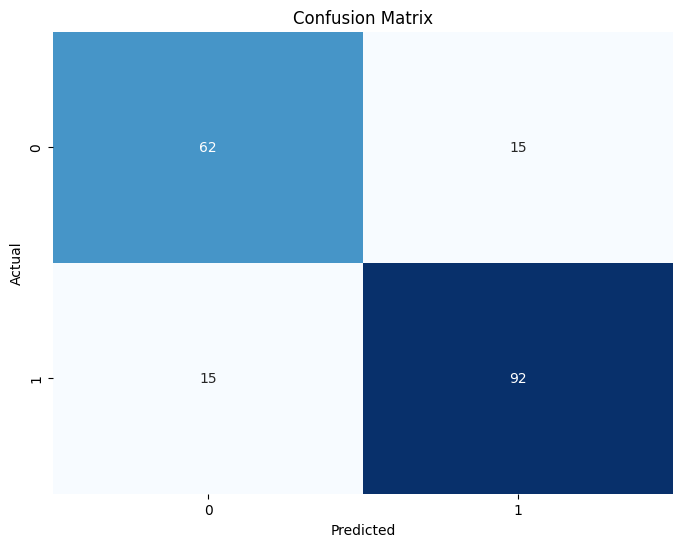

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### LGBM

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1)
    }

    clf = lgb.LGBMClassifier(**params)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    f1 = f1_score(y_test, y_pred)

    # Return 1 - F1-score to maximize F1-score
    return 1 - f1


study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best parameters:", best_params)

best_clf = lgb.LGBMClassifier(**best_params)
best_clf.fit(X_train, y_train)

y_train_pred = best_clf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)

y_pred = best_clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Akurasi: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


[I 2024-05-05 14:25:14,900] A new study created in memory with name: no-name-f71156b0-5308-42a5-9837-34e9c41704eb
[I 2024-05-05 14:25:15,008] Trial 0 finished with value: 0.09433962264150941 and parameters: {'num_leaves': 41, 'learning_rate': 0.06617198323189141, 'feature_fraction': 0.897236152805594, 'bagging_fraction': 0.6939847462580139, 'bagging_freq': 6, 'max_depth': 3, 'min_child_samples': 7, 'min_child_weight': 0.0010326300013565144}. Best is trial 0 with value: 0.09433962264150941.
[I 2024-05-05 14:25:15,121] Trial 1 finished with value: 0.10132158590308371 and parameters: {'num_leaves': 9, 'learning_rate': 0.002152731709688593, 'feature_fraction': 0.7032247515411753, 'bagging_fraction': 0.4093401626856359, 'bagging_freq': 7, 'max_depth': 9, 'min_child_samples': 13, 'min_child_weight': 0.038625497439262094}. Best is trial 0 with value: 0.09433962264150941.
[I 2024-05-05 14:25:15,195] Trial 2 finished with value: 0.13043478260869568 and parameters: {'num_leaves': 14, 'learning_r

Best parameters: {'num_leaves': 27, 'learning_rate': 0.0178135684107332, 'feature_fraction': 0.9051894450549149, 'bagging_fraction': 0.585578915656658, 'bagging_freq': 8, 'max_depth': 5, 'min_child_samples': 7, 'min_child_weight': 0.008602193088688134}
[LightGBM] [Warning] feature_fraction is set=0.9051894450549149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9051894450549149
[LightGBM] [Warning] bagging_fraction is set=0.585578915656658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585578915656658
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9051894450549149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9051894450549149
[LightGBM] [Warning] bagging_fraction is set=0.585578915656658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585578915656658
[LightGBM] [Warning] bagging_freq is set=

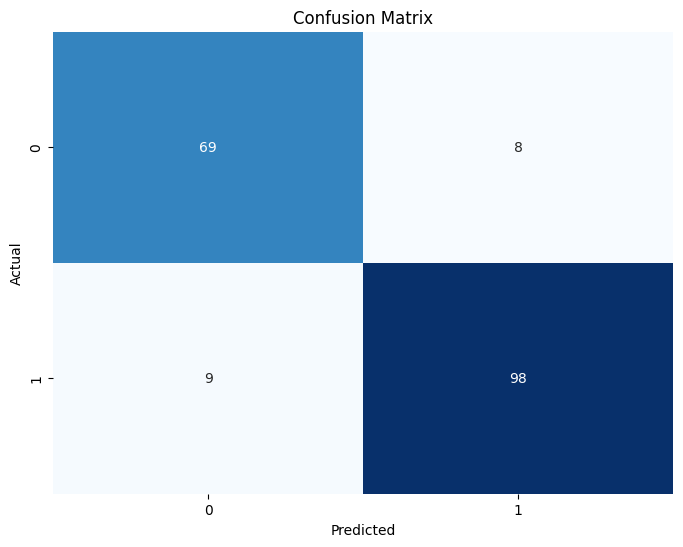

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


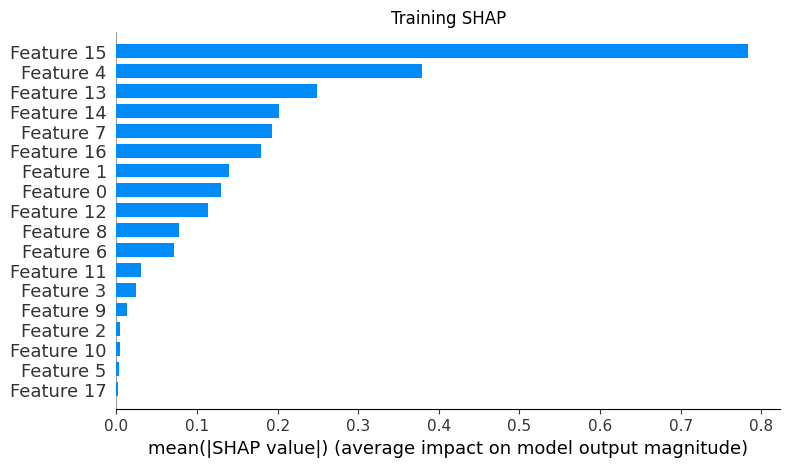

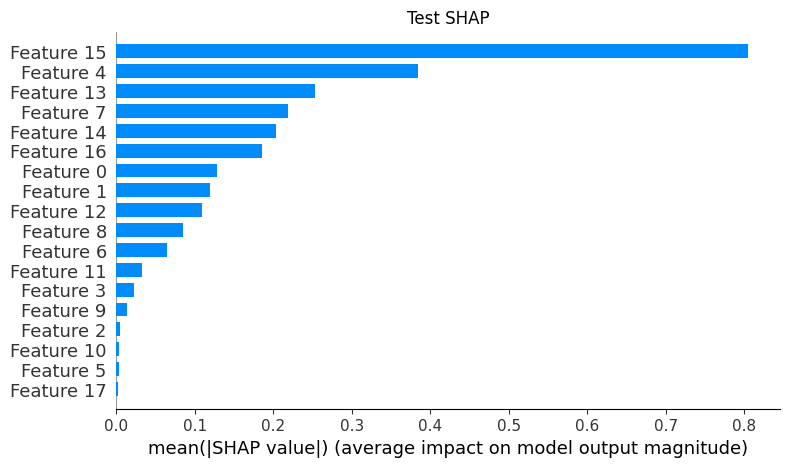

In [ ]:
train_shap_values = shap.TreeExplainer(best_clf).shap_values(X_train)
test_shap_values = shap.TreeExplainer(best_clf).shap_values(X_test)

plt.subplot(2, 1, 1)
plt.title('Training SHAP')
shap.summary_plot(train_shap_values, X_train, plot_type="bar")

plt.subplot(2, 1, 2)
plt.title('Test SHAP')
shap.summary_plot(test_shap_values, X_test, plot_type="bar");